# 1- Importer les données

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 250
pd.options.display.max_colwidth = 160
from ast import literal_eval
import random
import mailbox
import email as eml
import re
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, chi2
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
alg_random_state = 1746
random.seed(123)
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
from gensim.models import Word2Vec
import language_tool_python
from nltk.tokenize import word_tokenize as tokenize
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

In [2]:
def verifier_types_texte(message):
    type_liste = ['text/plain', 'text/html']
    content_type = message.get_content_type()
    if content_type in type_liste:
        return content_type
    else:
        return None

In [11]:
def mbox_vers_df(nom_fichier, chemin_fichier,texte_seulement=True):
    fichier = os.path.join(chemin_fichier, nom_fichier)
    mbox = mailbox.mbox(fichier)

    donnees = []
    compteur_sauts = 0

    # Parcours du fichier mbox
    for cle in mbox.iterkeys(): 
        try:
            message = mbox[cle]
        except UnicodeDecodeError:
            compteur_sauts += 1
            continue

        corps = None
        if verifier_types_texte(message):
            payload = message.get_payload(decode=True)
            if payload is not None:
                corps = payload.decode('utf-8', 'ignore')
        

        ligne = {
            'de': message.get('From'),
            'a': message.get('To'),
            'cc': message.get('Cc'),
            'bcc': message.get('Bcc'),
            'sujet': message.get('Subject'),
            'date': message.get('Date'),
            'message_id': message.get('Message-ID'),
            'in_reply_to': message.get('In-Reply-To'),
            'references': message.get('References'),
            'corps': corps
        }

        donnees.append(ligne)

    if compteur_sauts > 0:
        print(f"{compteur_sauts} e-mails sautés : Les en-têtes contiennent des caractères non-ascii ou des données d'e-mail corrompues.")
        
    dataframe = pd.DataFrame(donnees)
    return dataframe

In [12]:
def lire_ensemble_de_donnees(chemin, exceptions, text_only=True):
    mbox_fichiers = os.listdir(chemin)
    mbox_fichiers = [nom for nom in mbox_fichiers if nom not in exceptions]
    ensemble_de_donnees = pd.DataFrame()
    for fichier in mbox_fichiers:
        print("Lecture du fichier:", fichier)
        donnees_fichier = mbox_vers_df(fichier, chemin, text_only)
        ensemble_de_donnees = pd.concat([ensemble_de_donnees, donnees_fichier], ignore_index=True)
    return ensemble_de_donnees

In [13]:
def sauvegarder_en_csv(data, chemin, nom_fichier):
    nom_fichier_tenté = os.path.join(chemin, nom_fichier)
    if os.path.exists(nom_fichier_tenté):
        print("Le fichier", nom_fichier_tenté, "existe déjà.")
        ecraser = input("Voulez-vous l'écraser ? (o/n) ")
        if (ecraser == 'O' or ecraser == 'o'):
            print("Le fichier", nom_fichier_tenté, "sera écrasé.")
            data.to_csv(os.path.join(chemin, nom_fichier), index=False)
        else:
            print("Abandon, les données ne seront pas écrites.")
    else:
        print("Sauvegarde dans", nom_fichier_tenté)
        data.to_csv(os.path.join(chemin, nom_fichier), index=False)

In [14]:
def echantillonner_enron_vers_mbox(chemin, nombre, mode='nombre', ecraser=True):
    ignorer_dossiers = ['discussion_threads', '_sent_mail', 'all_documents']
    maildir_chemin = os.path.join(chemin, 'maildir')

    dossiers = [racine for racine, dossiers, fichiers in os.walk(maildir_chemin)
               if fichiers and not any([ignoré in racine for ignoré in ignorer_dossiers])]
    print(len(dossiers), "dossiers seront vérifiés.")

    emails_liste = [os.path.join(dossier, fichier) for dossier in dossiers
                  for fichier in os.scandir(dossier) if not fichier.is_dir()]
    print(len(emails_liste), "e-mails trouvés.")

    if (mode == 'pourcentage'):
        if (nombre > 1 or nombre <= 0):
            raise ValueError("Le pourcentage doit être entre 0 et 1.")
        else:
            nombre_email = int(nombre*len(emails_liste))
    elif (mode == 'nombre'):
        if (nombre <= 0):
            raise ValueError("Le nombre d'e-mails doit être positif.")
        else:
            nombre_email = int(nombre)
    else:
        raise ValueError("Ce mode n'existe pas:", mode)

    print("Extraction de", nombre_email, "e-mails aléatoires.")

    mbox_repertoire = os.path.join(chemin, 'mbox')
    if not os.path.exists(mbox_repertoire):
        os.makedirs(mbox_repertoire)

    fichier_mbox = os.path.join(mbox_repertoire,'enron_'+str(nombre_email)+'.mbox')
    if os.path.exists(fichier_mbox):
        if(ecraser):
            print("Le fichier", fichier_mbox, "sera écrasé.")
            os.remove(fichier_mbox)
        else:
            print("Le fichier", fichier_mbox, "existe déjà mais 'ecraser' "\
                "est défini sur False. L'opération s'arrêtera.")
            return None
    else:
        print("Création du fichier de sortie", fichier_mbox)

    mbox = mailbox.mbox(fichier_mbox)
    mbox.lock()

    random.shuffle(emails_liste)
    compteur_sauts = 0
    for email_fichier in emails_liste:
        if (nombre_email == 0):
            break
        else:
            try:
                email = eml.message_from_file(open(email_fichier))
                mbox.add(email)
                mbox.flush()
            except UnicodeDecodeError:
                compteur_sauts += 1
                continue
            else:
                nombre_email -= 1

    if (compteur_sauts > 0):
        print(compteur_sauts, "e-mails sautés : Les en-têtes contiennent des caractères non-ASCII "\
            "ou des données d'e-mail corrompues.")
    mbox.unlock()
    mbox.close()
    print(fichier_mbox, "a été créé avec succès.")
    return os.path.basename(fichier_mbox)

In [15]:
cwd = os.getcwd()
nazario_path = "C:\\Users\\user\\Desktop\\~jose\\phishing"
enron_path = "C:\\Users\\user\\Desktop\\enron"
csv_path = "C:\\Users\\user\\Desktop\\dataset"
files_ignored = ['README.txt']
phishing = lire_ensemble_de_donnees(nazario_path, files_ignored, text_only=True)

Lecture du fichier: 20051114.mbox
Lecture du fichier: phishing-2015
Lecture du fichier: phishing-2016
Lecture du fichier: phishing-2017
Lecture du fichier: phishing-2018
Lecture du fichier: phishing-2019
Lecture du fichier: phishing-2020
Lecture du fichier: phishing-2021
Lecture du fichier: phishing-2022
Lecture du fichier: phishing-2023
Lecture du fichier: phishing0.mbox
Lecture du fichier: phishing1.mbox
Lecture du fichier: phishing2.mbox


In [16]:
sauvegarder_en_csv(phishing, csv_path, 'nazario_dataset.csv')

Sauvegarde dans C:\Users\user\Desktop\dataset\nazario_dataset.csv


In [17]:
filename = echantillonner_enron_vers_mbox(enron_path, 20000)
enron_20000 = mbox_vers_df(filename, enron_path+'/mbox', texte_seulement=True)
sauvegarder_en_csv(enron_20000, csv_path, 'enron_text_20000.csv')

513 dossiers seront vérifiés.
32068 e-mails trouvés.
Extraction de 20000 e-mails aléatoires.
Le fichier C:\Users\user\Desktop\enron\mbox\enron_20000.mbox sera écrasé.
C:\Users\user\Desktop\enron\mbox\enron_20000.mbox a été créé avec succès.
Sauvegarde dans C:\Users\user\Desktop\dataset\enron_text_20000.csv


In [18]:
filename = echantillonner_enron_vers_mbox(enron_path, 2279)
enron_2279 = mbox_vers_df(filename, enron_path+'/mbox', texte_seulement=True)
sauvegarder_en_csv(enron_2279, csv_path, 'enron_text_2279.csv')

513 dossiers seront vérifiés.
32068 e-mails trouvés.
Extraction de 2279 e-mails aléatoires.
Le fichier C:\Users\user\Desktop\enron\mbox\enron_2279.mbox sera écrasé.
C:\Users\user\Desktop\enron\mbox\enron_2279.mbox a été créé avec succès.
Sauvegarde dans C:\Users\user\Desktop\dataset\enron_text_2279.csv


In [ ]:
filename = echantillonner_enron_vers_mbox(enron_path, 1000)
enron_1000 = mbox_vers_df(filename, enron_path+'/mbox', texte_seulement=True)
sauvegarder_en_csv(enron_1000, csv_path, 'enron_text_1000.csv')

513 dossiers seront vérifiés.
32068 e-mails trouvés.
Extraction de 1000 e-mails aléatoires.
Le fichier C:\Users\user\Desktop\enron\mbox\enron_1000.mbox sera écrasé.


In [ ]:
nazario_fichier_path = "C:\\Users\\user\\Desktop\\dataset\\nazario_dataset.csv"
enron_fichier1_path = "C:\\Users\\user\\Desktop\\dataset\\enron_text_20000.csv"
enron_fichier2_path = "C:\\Users\\user\\Desktop\\dataset\\enron_text_2279.csv"

phishing_text = pd.read_csv(nazario_fichier_path)
legitime_text1 = pd.read_csv(enron_fichier1_path)
legitime_text2 = pd.read_csv(enron_fichier2_path)

In [ ]:
enron_fichier3_path = "C:\\Users\\user\\Desktop\\dataset\\enron_text_1000.csv"
legitime = pd.read_csv(enron_fichier3_path)

# 2 - Prétraitement

## Netoyage

In [ ]:
def verifier_email_vide(input_string):
    """
    Vérifie si une chaîne de caractères correspond à un e-mail vide.
    """
    if input_string.strip():
        return False
    else:
        return True

In [ ]:
legitime['entete'] = legitime.apply(lambda row: ';'.join([str(row[col]) for col in ['de', 'a', 'cc', 'bcc', 'sujet', 'date', 'message_id', 'in_reply_to']]), axis=1)

In [ ]:
legitime.drop(['de', 'a', 'cc', 'bcc', 'sujet', 'date', 'message_id', 'in_reply_to','references'], axis=1, inplace=True)

In [ ]:
phishing_text['entete'] = phishing_text.apply(lambda row: ';'.join([str(row[col]) for col in ['de', 'a', 'cc', 'bcc', 'sujet', 'date', 'message_id', 'in_reply_to']]), axis=1)

In [ ]:
phishing_text.drop(['de', 'a', 'cc', 'bcc', 'sujet', 'date', 'message_id', 'in_reply_to','references'], axis=1, inplace=True)

In [ ]:
legitime_text2['entete'] = legitime_text2.apply(lambda row: ';'.join([str(row[col]) for col in ['de', 'a', 'cc', 'bcc', 'sujet', 'date', 'message_id', 'in_reply_to']]), axis=1)

In [ ]:
legitime_text2.drop(['de', 'a', 'cc', 'bcc', 'sujet', 'date', 'message_id', 'in_reply_to','references'], axis=1, inplace=True)

In [ ]:
legitime_text1['entete'] = legitime_text1.apply(lambda row: ';'.join([str(row[col]) for col in ['de', 'a', 'cc', 'bcc', 'sujet', 'date', 'message_id', 'in_reply_to']]), axis=1)

In [ ]:
legitime_text1.drop(['de', 'a', 'cc', 'bcc', 'sujet', 'date', 'message_id', 'in_reply_to','references'], axis=1, inplace=True)

In [ ]:
phishing_text.shape

In [ ]:
legitime_text2.shape

In [ ]:
legitime_text1.shape

In [ ]:
legitime.shape

In [ ]:
phishing_text.isnull().sum()

In [ ]:
legitime_text2.isnull().sum()

In [ ]:
legitime_text1.isnull().sum()

In [ ]:
legitime.isnull().sum()

In [ ]:
phishing_text=phishing_text.dropna()
legitime_text2=legitime_text2.dropna()
legitime_text1=legitime_text1.dropna()

In [ ]:
phishing_text.shape

In [ ]:
legitime_text2.shape

In [ ]:
phishing_text = phishing_text[phishing_text['corps'].apply(verifier_email_vide) == False]
legitime_text2 = legitime_text2[legitime_text2['corps'].apply(verifier_email_vide) == False]
legitime_text1 = legitime_text1[legitime_text1['corps'].apply(verifier_email_vide) == False]

In [ ]:
doublons = phishing_text.duplicated()
print(doublons.sum())

In [ ]:
doublons = legitime_text2.duplicated()
print(doublons.sum())

In [ ]:
doublons = legitime_text1.duplicated()
print(doublons.sum())

In [ ]:
phishing_text = phishing_text[phishing_text.duplicated(keep='first') == False]
legitime_text2 = legitime_text2[legitime_text2.duplicated(keep='first') == False]
legitime_text1 = legitime_text1[legitime_text1.duplicated(keep='first') == False]

In [ ]:
phishing_text = phishing_text[phishing_text['corps'].str.contains("This text is part of the internal format of your mail folder, and is not\na real message.") == False]
legitime_text2 = legitime_text2[legitime_text2['corps'].str.contains("This text is part of the internal format of your mail folder, and is not\na real message.") == False]
legitime_text1 = legitime_text1[legitime_text1['corps'].str.contains("This text is part of the internal format of your mail folder, and is not\na real message.") == False]

In [ ]:
phishing_text.shape

In [ ]:
legitime_text2.shape

In [ ]:
legitime_text1.shape

## Mixer les données

In [ ]:
phishing_text['class'] = 1
legitime['class'] = 0

In [ ]:
dataset0= pd.concat([phishing_text, legitime])
dataset0.insert(0, 'id', dataset0.index)

In [ ]:
sauvegarder_en_csv(dataset0, csv_path, 'dataset0.csv')

In [ ]:
phishing_text['class'] = 1
legitime_text1['class'] = 0
legitime_text1=legitime_text1.sample(n=20000,random_state=1746)

In [ ]:
dataset1 = pd.concat([phishing_text, legitime_text1])
dataset1.insert(0, 'id', dataset1.index)

In [ ]:
sauvegarder_en_csv(dataset1, csv_path, 'dataset1.csv')

In [ ]:
phishing_text['class'] = 1
legitime_text2['class'] = 0

In [ ]:
dataset2 = pd.concat([phishing_text, legitime_text2])
dataset2.insert(0, 'id', dataset2.index)

In [ ]:
sauvegarder_en_csv(dataset2, csv_path, 'dataset2.csv')

In [ ]:
balanced = pd.read_csv('C:\\Users\\user\\Desktop\\dataset\\dataset2.csv')
imbalanced = pd.read_csv('C:\\Users\\user\\Desktop\\dataset\\dataset1.csv')

In [ ]:
imbalanced1 = pd.read_csv('C:\\Users\\user\\Desktop\\dataset\\dataset0.csv')

In [ ]:
balanced.info()

In [ ]:
imbalanced.info()

In [ ]:
imbalanced1.info()

In [ ]:
count_class = balanced['class'].value_counts()
colors = sns.color_palette("Purples", n_colors=3)
plt.figure(figsize=(8, 8))
plt.pie(count_class, labels=count_class.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution des emails legitimes et phishing')
plt.show()

In [ ]:
count_class = imbalanced['class'].value_counts()
colors = sns.color_palette("Purples", n_colors=3)
plt.figure(figsize=(8, 8))
plt.pie(count_class, labels=count_class.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution des emails legitimes et phishing')
plt.show()

In [ ]:
count_class = imbalanced1['class'].value_counts()
colors = sns.color_palette("Purples", n_colors=3)
plt.figure(figsize=(8, 8))
plt.pie(count_class, labels=count_class.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution des emails legitimes et phishing')
plt.show()

## Extraire les composants

In [ ]:
import re
from html import unescape

def traiter_corps_email(corps):
    corps_decode = unescape(corps)
    liens = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', corps_decode)
    
    return corps_decode, liens

In [ ]:
balanced['corps_decode'], balanced['liens'] = zip(*balanced['corps'].apply(traiter_corps_email))

In [ ]:
imbalanced['corps_decode'], imbalanced['liens'] = zip(*imbalanced['corps'].apply(traiter_corps_email))

In [ ]:
imbalanced1['corps_decode'], imbalanced1['liens'] = zip(*imbalanced1['corps'].apply(traiter_corps_email))

In [ ]:
balanced.drop(['corps'], axis=1, inplace=True)

In [ ]:
imbalanced.drop(['corps'], axis=1, inplace=True)

In [ ]:
imbalanced1.drop(['corps'], axis=1, inplace=True)

# 2 - Analyser le corps 

## text processing

In [564]:
text_analys = imbalanced1.copy()

In [ ]:
text_analys = balanced.copy()

In [ ]:
text_analys.drop(['entete', 'liens'], axis=1, inplace=True)

### 1 - Assurer que le texte est en minuscules.

In [ ]:
def to_lower(text):
    return text.lower()

In [ ]:
text_analys['corps_decode'] = text_analys['corps_decode'].apply(to_lower)

### 2 - Supprimer la ponctuation.

In [ ]:
def html_remove(text):
    text = re.sub('<[^<]+?>', '', text)
    return text

In [ ]:
text_analys['corps_decode'] = text_analys['corps_decode'].apply(html_remove)

### 3-Remplacer les liens et les adresses email

In [ ]:
def remplacer_adresse_email(input_string, replacement_string='AdresseEmail'):
    
    output_string = re.sub(r'\b[A-Za-z0-9._%+-]+@([A-Za-z0-9.-]+\.[A-Z|a-z]{2,})\b', '<adresse_email>', input_string)
    return output_string

In [ ]:
def remplacer_adresse_url(input_string, replacement_string='AdresseUrl'):
    output_string = re.sub(r'((http|ftp|https)\:\/\/)?([\w_\.-]+(?:\.(zw|zuerich|zone|zm|zip|zero|zara|zappos|za|yun|yt|youtube|you|yokohama|yoga|yodobashi|ye|yandex|yamaxun|yahoo|yachts|xyz|xxx|xn--zfr164b|xn--ygbi2ammx|xn--yfro4i67o|xn--y9a3aq|xn--xkc2dl3a5ee0h|xn--xkc2al3hye2a|xn--xhq521b|xn--wgbl6a|xn--wgbh1c|xn--w4rs40l|xn--w4r85el8fhu5dnra|xn--vuq861b|xn--vhquv|xn--vermgensberatung-pwb|xn--vermgensberater-ctb|xn--unup4y|xn--tiq49xqyj|xn--tckwe|xn--t60b56a|xn--ses554g|xn--s9brj9c|xn--rvc1e0am3e|xn--rovu88b|xn--rhqv96g|xn--qxam|xn--qxa6a|xn--qcka1pmc|xn--q9jyb4c|xn--q7ce6a|xn--pssy2u|xn--pgbs0dh|xn--p1ai|xn--p1acf|xn--otu796d|xn--ogbpf8fl|xn--o3cw4h|xn--nyqy26a|xn--nqv7fs00ema|xn--nqv7f|xn--node|xn--ngbrx|xn--ngbe9e0a|xn--ngbc5azd|xn--mxtq1m|xn--mk1bu44c|xn--mix891f|xn--mgbx4cd0ab|xn--mgbtx2b|xn--mgbt3dhd|xn--mgbpl2fh|xn--mgbi4ecexp|xn--mgbgu82a|xn--mgberp4a5d4ar|xn--mgbcpq6gpa1a|xn--mgbca7dzdo|xn--mgbc0a9azcg|xn--mgbbh1a71e|xn--mgbbh1a|xn--mgbayh7gpa|xn--mgbai9azgqp6j|xn--mgbah1a3hjkrd|xn--mgbab2bd|xn--mgbaam7a8h|xn--mgbaakc7dvf|xn--mgba7c0bbn0a|xn--mgba3a4f16a|xn--mgba3a3ejt|xn--mgb9awbf|xn--lgbbat1ad8j|xn--l1acc|xn--kput3i|xn--kpry57d|xn--kprw13d|xn--kcrx77d1x4a|xn--jvr189m|xn--jlq61u9w7b|xn--jlq480n2rg|xn--j6w193g|xn--j1amh|xn--j1aef|xn--io0a7i|xn--imr513n|xn--i1b6b1a6a2e|xn--hxt814e|xn--h2brj9c8c|xn--h2brj9c|xn--h2breg3eve|xn--gk3at1e|xn--gecrj9c|xn--gckr3f0f|xn--g2xx48c|xn--fzys8d69uvgm|xn--fzc2c9e2c|xn--fpcrj9c3d|xn--flw351e|xn--fjq720a|xn--fiqz9s|xn--fiqs8s|xn--fiq64b|xn--fiq228c5hs|xn--fhbei|xn--fct429k|xn--efvy88h|xn--eckvdtc9d|xn--e1a4c|xn--d1alf|xn--d1acj3b|xn--czru2d|xn--czrs0t|xn--czr694b|xn--clchc0ea0b2g2a9gcd|xn--cg4bki|xn--cckwcxetd|xn--cck2b3b|xn--c2br7g|xn--c1avg|xn--bck1b9a5dre4c|xn--b4w605ferd|xn--9krt00a|xn--9et52u|xn--9dbq2a|xn--90ais|xn--90ae|xn--90a3ac|xn--8y0a063a|xn--80aswg|xn--80asehdb|xn--80aqecdr1a|xn--80ao21a|xn--80adxhks|xn--6qq986b3xl|xn--6frz82g|xn--5tzm5g|xn--5su34j936bgsg|xn--55qx5d|xn--55qw42g|xn--54b7fta0cc|xn--4gbrim|xn--4dbrk0ce|xn--45q11c|xn--45brj9c|xn--45br5cyl|xn--42c2d9a|xn--3pxu8k|xn--3hcrj9c|xn--3e0b707e|xn--3ds443g|xn--3bst00m|xn--30rr7y|xn--2scrj9c|xn--1qqw23a|xn--1ck2e1b|xn--11b4c3d|xin|xihuan|xfinity|xerox|xbox|wtf|wtc|ws|wow|world|works|work|woodside|wolterskluwer|wme|winners|wine|windows|win|williamhill|wiki|wien|whoswho|wf|weir|weibo|wedding|wed|website|weber|webcam|weatherchannel|weather|watches|watch|wanggou|wang|walter|walmart|wales|vuelos|vu|voyage|voto|voting|vote|volvo|volkswagen|vodka|vn|vlaanderen|vivo|viva|vision|visa|virgin|vip|vin|villas|viking|vig|video|viajes|vi|vg|vet|versicherung|verisign|ventures|vegas|ve|vc|vanguard|vana|vacations|va|uz|uy|us|ups|uol|uno|university|unicom|uk|ug|ubs|ubank|ua|tz|tw|tvs|tv|tushu|tunes|tui|tube|tt|trv|trust|travelersinsurance|travelers|travelchannel|travel|training|trading|trade|tr|toys|toyota|town|tours|total|toshiba|toray|top|tools|tokyo|today|to|tn|tmall|tm|tl|tkmaxx|tk|tjx|tjmaxx|tj|tirol|tires|tips|tiffany|tienda|tickets|tiaa|theatre|theater|thd|th|tg|tf|teva|tennis|temasek|tel|technology|tech|team|tdk|td|tci|tc|taxi|tax|tattoo|tatar|tatamotors|target|taobao|talk|taipei|tab|sz|systems|sydney|sy|sx|swiss|swatch|sv|suzuki|surgery|surf|support|supply|supplies|sucks|su|style|study|studio|stream|store|storage|stockholm|stcgroup|stc|statefarm|statebank|star|staples|stada|st|ss|srl|sr|spot|sport|space|spa|soy|sony|song|solutions|solar|sohu|software|softbank|social|soccer|so|sncf|sn|smile|smart|sm|sling|sl|skype|sky|skin|ski|sk|sj|site|singles|sina|silk|si|showtime|show|shouji|shopping|shop|shoes|shiksha|shia|shell|shaw|sharp|shangrila|sh|sg|sfr|sexy|sex|sew|seven|ses|services|sener|select|seek|security|secure|seat|search|se|sd|scot|science|schwarz|schule|school|scholarships|schmidt|schaeffler|scb|sca|sc|sbs|sbi|sb|saxo|save|sas|sarl|sap|sanofi|sandvikcoromant|sandvik|samsung|samsclub|salon|sale|sakura|safety|safe|saarland|sa|ryukyu|rwe|rw|run|ruhr|rugby|ru|rsvp|rs|room|rogers|rodeo|rocks|rocher|ro|rip|rio|ril|ricoh|richardli|rich|rexroth|reviews|review|restaurant|rest|republican|report|repair|rentals|rent|ren|reliance|reit|reisen|reise|rehab|redumbrella|redstone|red|recipes|realty|realtor|realestate|read|re|radio|racing|quest|quebec|qpon|qa|py|pwc|pw|pub|pt|ps|prudential|pru|protection|property|properties|promo|progressive|prof|productions|prod|pro|prime|press|praxi|pramerica|pr|post|porn|politie|poker|pohl|pnc|pn|pm|plus|plumbing|playstation|play|place|pl|pk|pizza|pioneer|pink|ping|pin|pid|pictures|pictet|pics|physio|photos|photography|photo|phone|philips|phd|pharmacy|ph|pg|pfizer|pf|pet|pe|pccw|pay|passagens|party|parts|partners|pars|paris|panasonic|page|pa|ovh|ott|otsuka|osaka|origins|organic|org|orange|oracle|open|ooo|online|onl|ong|one|omega|om|ollo|oldnavy|olayangroup|olayan|okinawa|office|observer|obi|nz|nyc|nu|ntt|nrw|nra|nr|np|nowtv|nowruz|now|norton|northwesternmutual|nokia|no|nl|nissay|nissan|ninja|nikon|nike|nico|ni|nhk|ngo|ng|nfl|nf|nexus|nextdirect|next|news|new|neustar|network|netflix|netbank|net|nec|ne|nc|nba|navy|natura|name|nagoya|nab|na|mz|my|mx|mw|mv|mutual|music|museum|mu|mtr|mtn|mt|msd|ms|mr|mq|mp|movie|mov|motorcycles|moto|moscow|mortgage|mormon|monster|money|monash|mom|moi|moe|moda|mobile|mobi|mo|mn|mma|mm|mls|mlb|ml|mk|mitsubishi|mit|mint|mini|mil|microsoft|miami|mh|mg|merckmsd|menu|men|memorial|meme|melbourne|meet|media|med|me|md|mckinsey|mc|mba|mattel|maserati|marshalls|marriott|markets|marketing|market|map|mango|management|man|makeup|maison|maif|madrid|macys|ma|ly|lv|luxury|luxe|lundbeck|lu|ltda|ltd|lt|ls|lr|lplfinancial|lpl|love|lotto|lotte|london|lol|loft|locus|locker|loans|loan|llp|llc|lk|living|live|lipsy|link|linde|lincoln|limo|limited|lilly|like|lighting|lifestyle|lifeinsurance|life|lidl|li|lgbt|lexus|lego|legal|lefrak|leclerc|lease|lds|lc|lb|lawyer|law|latrobe|latino|lat|lasalle|lanxess|landrover|land|lancia|lancaster|lamer|lamborghini|lacaixa|la|kz|kyoto|ky|kw|kuokgroup|kred|krd|kr|kpn|kpmg|kp|kosher|komatsu|koeln|kn|km|kiwi|kitchen|kindle|kinder|kim|kids|kia|ki|kh|kg|kfh|kerryproperties|kerrylogistics|kerryhotels|ke|kddi|kaufen|juniper|juegos|jprs|jpmorgan|jp|joy|jot|joburg|jobs|jo|jnj|jmp|jm|jll|jio|jewelry|jetzt|jeep|je|jcb|java|jaguar|itv|itau|it|istanbul|ist|ismaili|is|irish|ir|iq|ipiranga|io|investments|intuit|international|int|insure|insurance|institute|ink|ing|info|infiniti|industries|inc|in|immobilien|immo|imdb|imamat|im|il|ikano|ifm|ieee|ie|id|icu|ice|icbc|ibm|hyundai|hyatt|hughes|hu|ht|hsbc|hr|how|house|hotmail|hotels|hoteles|hot|hosting|host|hospital|horse|honda|homesense|homes|homegoods|homedepot|holiday|holdings|hockey|hn|hm|hkt|hk|hiv|hitachi|hisamitsu|hiphop|hgtv|hermes|here|helsinki|help|healthcare|health|hdfcbank|hdfc|hbo|haus|hangout|hamburg|hair|gy|gw|guru|guitars|guide|guge|gucci|guardian|gu|gt|gs|group|grocery|gripe|green|gratis|graphics|grainger|gr|gq|gp|gov|got|gop|google|goog|goodyear|goo|golf|goldpoint|gold|godaddy|gn|gmx|gmo|gmbh|gmail|gm|globo|global|gle|glass|gl|giving|gives|gifts|gift|gi|gh|ggee|gg|gf|george|genting|gent|gea|ge|gdn|gd|gbiz|gb|gay|garden|gap|games|game|gallup|gallo|gallery|gal|ga|fyi|futbol|furniture|fund|fun|fujitsu|ftr|frontier|frontdoor|frogans|frl|fresenius|free|fr|fox|foundation|forum|forsale|forex|ford|football|foodnetwork|food|foo|fo|fm|fly|flowers|florist|flir|flights|flickr|fk|fj|fitness|fit|fishing|fish|firmdale|firestone|fire|financial|finance|final|film|fido|fidelity|fiat|fi|ferrero|ferrari|feedback|fedex|fast|fashion|farmers|farm|fans|fan|family|faith|fairwinds|fail|fage|extraspace|express|exposed|expert|exchange|events|eus|eurovision|eu|etisalat|et|estate|esq|es|erni|ericsson|er|equipment|epson|enterprises|engineering|engineer|energy|emerck|email|eg|ee|education|edu|edeka|eco|ec|eat|earth|dz|dvr|dvag|durban|dupont|dunlop|dubai|dtv|drive|download|dot|domains|dog|doctor|docs|do|dnp|dm|dk|dj|diy|dish|discover|discount|directory|direct|digital|diet|diamonds|dhl|dev|design|desi|dentist|dental|democrat|delta|deloitte|dell|delivery|degree|deals|dealer|deal|de|dds|dclk|day|datsun|dating|date|data|dance|dad|dabur|cz|cyou|cymru|cy|cx|cw|cv|cuisinella|cu|cruises|cruise|crs|crown|cricket|creditunion|creditcard|credit|cr|cpa|courses|coupons|coupon|country|corsica|coop|cool|cookingchannel|cooking|contractors|contact|consulting|construction|condos|comsec|computer|compare|company|community|commbank|comcast|com|cologne|college|coffee|codes|coach|co|cn|cm|clubmed|club|cloud|clothing|clinique|clinic|click|cleaning|claims|cl|ck|cityeats|city|citic|citi|citadel|cisco|circle|cipriani|ci|church|chrome|christmas|chintai|cheap|chat|chase|charity|channel|chanel|ch|cg|cfd|cfa|cf|cern|ceo|center|cd|cc|cbs|cbre|cbn|cba|catholic|catering|cat|casino|cash|case|casa|cars|careers|career|care|cards|caravan|car|capitalone|capital|capetown|canon|cancerresearch|camp|camera|cam|calvinklein|call|cal|cafe|cab|ca|bzh|bz|by|bw|bv|buzz|buy|business|builders|build|bugatti|bt|bs|brussels|brother|broker|broadway|bridgestone|bradesco|br|box|boutique|bot|boston|bostik|bosch|booking|book|boo|bond|bom|bofa|boehringer|boats|bo|bnpparibas|bn|bmw|bms|bm|blue|bloomberg|blog|blockbuster|blackfriday|black|bj|biz|bio|bingo|bing|bike|bid|bible|bi|bharti|bh|bg|bf|bet|bestbuy|best|berlin|bentley|beer|beauty|beats|be|bd|bcn|bcg|bbva|bbt|bbc|bb|bayern|bauhaus|basketball|baseball|bargains|barefoot|barclays|barclaycard|barcelona|bar|bank|band|bananarepublic|banamex|baidu|baby|ba|azure|az|axa|ax|aws|aw|avianca|autos|auto|author|auspost|audio|audible|audi|auction|au|attorney|athleta|at|associates|asia|asda|as|arte|art|arpa|army|archi|aramco|arab|ar|aquarelle|aq|apple|app|apartments|aol|ao|anz|anquan|android|analytics|amsterdam|amica|amfam|amex|americanfamily|americanexpress|amazon|am|alstom|alsace|ally|allstate|allfinanz|alipay|alibaba|alfaromeo|al|akdn|airtel|airforce|airbus|aig|ai|agency|agakhan|ag|africa|afl|af|aetna|aero|aeg|ae|adult|ads|adac|ad|actor|aco|accountants|accountant|accenture|academy|ac|abudhabi|abogado|able|abc|abbvie|abbott|abb|abarth|aarp|aaa)\b))([\w.,?^=%&@:/~+#-]*[\w?^=%&@/~+#-])?', replacement_string, input_string)
    return output_string

In [ ]:
text_analys['corps_decode'] = text_analys['corps_decode'].apply(remplacer_adresse_email)
text_analys['corps_decode'] = text_analys['corps_decode'].apply(remplacer_adresse_url)

### 4 - Supprimer les caractères spéciaux et les balises HTML s'il y en a.

In [ ]:
import string
def ponctuation(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

In [ ]:
text_analys['corps_decode'] = text_analys['corps_decode'].apply(ponctuation)

### 5 - Effectuer la tokenisation (division du texte en mots).

In [ ]:
def tokenize(input_text):

    lowercase = input_text.lower()
    token_list = nltk.word_tokenize(lowercase)
    clean_list = [word for word in token_list if len(re.findall(r'^[a-zA-Z0-9]+-?[\w-]*$', word)) == 1]

    return clean_list

In [ ]:
text_analys['corps_decode'] = text_analys['corps_decode'].apply(tokenize)

### 6 - Supprimer les mots vides (stopwords).

In [ ]:
def remove_stopwords(tokenized_text):
    stop_words = stopwords.words('english')
    clean_list = [word for word in tokenized_text if word not in stop_words]

    return clean_list


In [ ]:
text_analys['corps_decode'] = text_analys['corps_decode'].apply(remove_stopwords)

In [ ]:
print(text_analys['corps_decode'].iloc[7])

### 7 - Effectuer le stemming ou la lemmatisation pour ramener les mots à leur forme de base.

In [ ]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


In [ ]:
def lemmatize(token_list):

    lemmatizer = WordNetLemmatizer()
    tagged_list = nltk.pos_tag(token_list)

    lemmatized_list = [lemmatizer.lemmatize(word)
                       if get_wordnet_pos(tag) is None
                       else lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag))
                       for word, tag in tagged_list]

    return lemmatized_list


In [ ]:
text_analys['corps_decode'] = text_analys['corps_decode'].apply(lemmatize)

In [ ]:
print(text_analys['corps_decode'].iloc[7])

## Analyse du text

### feature extraction: Word2vec

In [ ]:
def filter_vocab_words(wordlist, vocabulary):

    return [word for word in wordlist if word in vocabulary]


In [ ]:
def get_mean_vector(wordlist, word2vec_model):
    
    if len(wordlist) >= 1:
        return np.mean(word2vec_model.wv[wordlist], axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)


In [ ]:
def word2vec_features(text_col_train, text_col_test=None, vector_size=100, min_count=5, max_vocab_size=None, workers=1):

    output = dict();
    
    model = Word2Vec(sentences=text_col_train,
                     min_count=min_count, vector_size=vector_size, max_final_vocab=max_vocab_size,
                     sg=1, workers=workers, seed=1746)
    
    vocab = list(model.wv.key_to_index.keys())
    
    filtered_col_train = text_col_train.apply(filter_vocab_words, vocabulary=vocab)
    col_with_means_train = filtered_col_train.apply(get_mean_vector, word2vec_model=model)    
    word2vec_features_train = pd.DataFrame(col_with_means_train.tolist())
    
    output['vectorizer'] = model
    output['word2vec_train'] = word2vec_features_train
    
    if text_col_test is not None:
        filtered_col_test = text_col_test.apply(filter_vocab_words, vocabulary=vocab)
        col_with_means_test = filtered_col_test.apply(get_mean_vector, word2vec_model=model)    
        word2vec_features_test = pd.DataFrame(col_with_means_test.tolist())
        
        output['word2vec_test'] = word2vec_features_test
    else:
        output['word2vec_features_test'] = None

    return output

In [ ]:
word2vec_imbalanced = word2vec_features(train_data['corps_decode'], test_data['corps_decode'], vector_size=100, min_count=5)

In [ ]:
word2vec_train_imbalanced = word2vec_imbalanced['word2vec_train']
word2vec_test_imbalanced = word2vec_imbalanced['word2vec_test']
word2vec_model_imbalanced = word2vec_imbalanced['vectorizer']

In [ ]:
word2vec_train_imbalanced

In [ ]:
final_word2vec_train_imbalanced = dataset_add_columns(word2vec_train_imbalanced,  [train_data['class']], column_names)
final_word2vec_test_imbalanced = dataset_add_columns(word2vec_test_imbalanced,  [test_data['class']], column_names)

In [ ]:
word2vec_train_imbalanced = separate_features_target(final_word2vec_train_imbalanced)
word2vec_test_imbalanced = separate_features_target(final_word2vec_test_imbalanced)

In [ ]:
lr_word2vec_imbalanced = train_logistic_regression(word2vec_train_imbalanced['features'], word2vec_train_imbalanced['target'], show_train_accuracy=1)
lr_word2vec_imbalanced, lr_word2vec_imbalanced_scaler = lr_word2vec_imbalanced['model'], lr_word2vec_imbalanced['scaler']

In [556]:
svm_word2vec_imbalanced = train_svm(word2vec_train_imbalanced['features'], word2vec_train_imbalanced['target'], show_train_accuracy=1)

Training accuracy: 0.9744567289363324


In [557]:
knn_word2vec_imbalanced = train_knn(word2vec_train_imbalanced['features'], word2vec_train_imbalanced['target'], show_train_accuracy=1)

Training accuracy: 0.9824628288219596


In [558]:
dt_word2vec_imbalanced = train_decision_tree(word2vec_train_imbalanced['features'], word2vec_train_imbalanced['target'], show_train_accuracy=1)

Training accuracy: 0.9790316431566908


In [559]:
rf_word2vec_imbalanced = train_random_forest(word2vec_train_imbalanced['features'], word2vec_train_imbalanced['target'], show_train_accuracy=1)

Training accuracy: 0.9817003431185666


In [560]:
gb_word2vec_imbalanced = train_gradient_boost(word2vec_train_imbalanced['features'], word2vec_train_imbalanced['target'], show_train_accuracy=1)

Training accuracy: 0.9977125428898208


In [561]:
nb_word2vec_imbalanced = train_naive_bayes(word2vec_train_imbalanced['features'], word2vec_train_imbalanced['target'], remove_negatives=True, show_train_accuracy=1)
nb_word2vec_imbalanced, nb_word2vec_imbalanced_scaler = nb_word2vec_imbalanced['model'], nb_word2vec_imbalanced['scaler']

Training accuracy: 0.8898208158597026


In [562]:
models = [lr_word2vec_imbalanced, svm_word2vec_imbalanced,knn_word2vec_imbalanced, dt_word2vec_imbalanced, rf_word2vec_imbalanced, gb_word2vec_imbalanced, nb_word2vec_imbalanced]
names = ['Logistic Regression', 'SVM', 'KNN','Decision Tree', 'Random Forest', 'Gradient Boosting Tree', 'Naive Bayes']

In [563]:
results_word2vec = multi_model_results(models, names, word2vec_test_imbalanced['features'], word2vec_test_imbalanced['target'], lr_word2vec_imbalanced_scaler, nb_word2vec_imbalanced_scaler)
results_word2vec

,accuracy,precision,recall,f1,auc,tn,fp,fn,tp
Logistic Regression,0.964939,0.974304,0.976395,0.975348,0.991597,178,12,11,455
SVM,0.974085,0.986985,0.976395,0.981661,0.992015,184,6,11,455
KNN,0.966463,0.984716,0.967811,0.976190,0.987091,183,7,15,451
Decision Tree,0.954268,0.969828,0.965665,0.967742,0.957505,176,14,16,450
Random Forest,0.967988,0.974414,0.980687,0.977540,0.994793,178,12,9,457
Gradient Boosting Tree,0.969512,0.974468,0.982833,0.978632,0.991484,178,12,8,458
Naive Bayes,0.885671,0.868173,0.989270,0.924774,0.983691,120,70,5,461


### feature extraction: TF-IDF

In [547]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [584]:
def dataset_split(dataset, percent=0.2, keep_index=False):

    train, test = train_test_split(dataset, test_size=percent/100, random_state=1746)

    if not keep_index:
        train = train.reset_index(drop=True)
        test = test.reset_index(drop=True)
    else:
        train = train.reset_index()
        test = test.reset_index()

    return train, test

In [585]:
train_data, test_data = dataset_split(text_analys, percent=20)

In [586]:
def tfidf_features(text_col_train, text_col_test=None, max_df=1.0, min_df=1, max_features=None):
    
    if all(isinstance(elem, str) for elem in text_col_train[0]):
        text_train = text_col_train.map(' '.join)
    else:
        raise TypeError("La colonne d'entrée doit contenir des listes de chaînes de caractères.")
    
    output = dict(); 
    
    tfidf_vec = TfidfVectorizer(stop_words=None, max_df=max_df, min_df=min_df, max_features=max_features)

    
    tfidf_score_train = tfidf_vec.fit_transform(text_train).toarray()
    tfidf_features_train = pd.DataFrame(tfidf_score_train, columns=tfidf_vec.get_feature_names_out())
    
    output['vectorizer'] = tfidf_vec
    output['tfidf_train'] = tfidf_features_train
    
    if text_col_test is not None:
        text_test = text_col_test.map(' '.join)
        
        tfidf_score_test = tfidf_vec.transform(text_test).toarray()
        tf_idf_features_test = pd.DataFrame(tfidf_score_test, columns=tfidf_vec.get_feature_names_out())
        
        output['tfidf_test'] = tf_idf_features_test
    else:
        output['tfidf_test'] = None
    
    return output


In [587]:
train_data.head()

,id,class,corps_decode
0,142,1,"[message, notify, message, message, td, fontfamily, verdanaarialhelveticasansseriffontsize, 12pxcolor, 000000, message, li, lineheight, 120, message, ulppsm..."
1,201,1,"[paypal, billing, dept, dear, paypal, member, paypal, commit, maintain, safe, environment, community, buyer, seller, protect, security, account, paypal, emp..."
2,1748,1,[]
3,598,0,"[propose, minor, revision, summary, description, 11301doc]"
4,339,0,"[case, didnt, receive, forward, arnold, l, eisensteinenrondevelopment, 04252001, 0224, pm, gary, choquetteenronenronxgate, 04252001, 1228, pm, william, kend..."


In [633]:
tfidf = tfidf_features(train_data['corps_decode'], test_data['corps_decode'], min_df=5, max_features=1000)

In [634]:
tfidf_train_data = tfidf['tfidf_train']
tfidf_test_data = tfidf['tfidf_test']
tfidf_model = tfidf['vectorizer']

In [635]:
from joblib import dump

dump(tfidf_model, 'tfidf_vectorizer.joblib')


['tfidf_vectorizer.joblib']

In [636]:
tfidf_train_data.head()

,000000,003366,02,0px,10,100,10px,10pxcolor,10pxfontweight,11,11px,11pxcolor,11pxfontweight,12,120,12px,12pxcolor,13,13px,14,15,15px,15pxfontweight,16,16pxcolor,16pxfontweight,17,18,18pxfontweight,1px,20,2000,2001,2002,2005,2006,2023,20px,20pxfontweight,21,23,24,25,26,2px,30,400,40px,48,480px,50,500,510,54pt,5px,700,713,72,aaaaaa,ability,able,accept,access,accord,accordance,account,act,action,activate,active,activity,add,additional,address,administrator,adresseemail,adresseurl,advance,advanced,advise,affiliate,agency,agent,agree,agreement,alert,allow,already,also,always,amazon,america,american,amount,analysis,analyst,andor,another,answer,antifraud,anyone,apologize,appear,apple,application,apply,appreciate,appropriate,approval,approve,april,area,arial,around,ask,asset,assist,assistance,associate,assume,attach,attachment,attempt,attend,attention,...,suspension,system,tab,table,tableinvoice,take,talk,tax,td,team,technology,tell,temporarily,temporary,term,terminate,termination,test,texas,text,textalign,textalignright,textdecoration,thank,thanks,theft,theimage,therefore,thing,think,third,three,thru,thursday,ticket,time,tip,today,together,tomorrow,top,total,track,trade,trademark,trader,trading,transaction,transfer,transmission,travel,trust,try,tuesday,turn,two,type,ulppnarrow,ulppsmallborder,unable,unauthorized,understand,union,unit,united,unsafe,unsubscribe,unusual,update,updated,upgrade,url,usd,use,user,value,var,verdana,verdanaarialhelveticasansserif,verdanaarialhelveticasansseriffontsize,verification,verify,version,via,view,violate,violation,visa,visible,visit,volume,want,warn,washington,way,weather,web,website,wednesday,week,welcome,well,welshdruid,west,whether,width,width100,williams,win,window,wish,within,without,work,world,would,write,yahoo,yard,year,yesterday,yet,york,youll,youre
0,0.245063,0.179539,0.0,0.169205,0.0,0.030327,0.03456,0.073495,0.037326,0.0,0.0,0.073495,0.036747,0.0,0.035551,0.0,0.036668,0.0,0.03475,0.0,0.0,0.0,0.037412,0.0,0.075351,0.036747,0.0,0.0,0.036747,0.0,0.0,0.0,0.000000,0.0,0.027793,0.0,0.0,0.035482,0.037675,0.0,0.0,0.0,0.000000,0.0,0.036129,0.0,0.034623,0.036055,0.0,0.0,0.0,0.0,0.0,0.0,0.103869,0.034314,0.0,0.0,0.036055,0.0,0.0,0.0,0.112776,0.0,0.033447,0.203996,0.0,0.0,0.000000,0.0,0.054794,0.0,0.062963,0.0,0.0,0.000000,0.014655,0.0,0.039775,0.0,0.0,0.0,0.0,0.0,0.025398,0.0,0.035009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039889,0.0,0.030444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.026834,0.037499,0.0,0.00000,0.000000,0.0,0.0,0.000000,...,0.032121,0.071256,0.0,0.0,0.0,0.0,0.0,0.0,0.03367,0.066129,0.0,0.0,0.0,0.032459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018634,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.044700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037675,0.038713,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.063867,0.000000,0.0,0.0,0.0,0.0,0.034717,0.022881,0.0,0.0,0.0,0.071384,0.364327,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033727,0.0,0.0,0.0,0.0,0.0,0.028393,0.0,0.0,0.033338,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.190566,0.0,0.070647,0.492437,0.0,0.0,0.083543,0.0,0.115736,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.084014,0.0,0.0,0.0,0.0,0.0,0.053646,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084254,0.0,0.064304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.057751,...,0.000000,0.150507,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.093118,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0

In [637]:
def chi2_feature_selection(features_train, class_col_train, features_test=None, percentile=50):

    output = dict(); 
    
    chi2_selector = SelectPercentile(chi2, percentile=percentile)
    
    chi2_features_train = chi2_selector.fit_transform(features_train, class_col_train)
    selected_features_train = pd.DataFrame(chi2_features_train, columns=chi2_selector.get_feature_names_out())
    
    output['selector'] = chi2_selector
    output['features_train'] = selected_features_train
    
    if features_test is not None:
        chi2_features_test = chi2_selector.transform(features_test)
        selected_features_test = pd.DataFrame(chi2_features_test, columns=chi2_selector.get_feature_names_out())
        
        output['features_test'] = selected_features_test
    else:
        output['features_test'] = None
        
    return output

In [638]:
selected_tfidf= chi2_feature_selection(tfidf_train_data, train_data['class'], tfidf_test_data, percentile=50)
tfidf_sel_train = selected_tfidf['features_train']
tfidf_sel_test = selected_tfidf['features_test']
tfidf_sel_model = selected_tfidf['selector']

In [639]:
# Sauvegarde du sélecteur de caractéristiques
dump(tfidf_sel_model, 'feature_selector.joblib')


['feature_selector.joblib']

In [640]:
tfidf_sel_train.head()

,000000,003366,0px,10px,10pxcolor,11,11pxcolor,13px,16pxcolor,2000,2001,2002,2005,2006,2023,20px,24,25,26,30,48,50,510,54pt,5px,713,access,accordance,account,action,activate,activity,address,administrator,adresseurl,agent,also,amazon,america,analysis,analyst,apologize,apple,approval,area,arial,around,asset,assistance,attach,attempt,attend,attention,august,authenticate,available,avoid,back,backgroundcolor,bank,banking,bass,begin,bellow,big,billing,blair,block,board,bob,boldcolor,book,brand,bring,brown,browser,build,business,button,buyer,calendar,california,call,card,cash,cause,cc,central,chase,child,choose,chris,click,closure,color,come,comment,commit,community,company,complete,compromised,conference,confirm,continue,contract,control,cooperation,copy,copyright,corner,corp,cost,create,credit,ct,customer,cut,daily,database,date,david,davis,day,de,...,register,regularly,renew,reply,report,request,require,reserve,resolve,respective,respond,response,restore,result,richard,rick,right,risk,robert,rule,safe,safety,sally,sansserif,saturday,save,say,schedule,scott,screen,season,secure,security,see,seller,sensitive,sent,september,seriffontsize,server,service,since,sincerely,sit,skilling,smith,solid,sore,spam,spoof,spread,staff,standard,steve,stock,street,subject,sunday,support,suspend,suspension,system,tableinvoice,talk,td,tell,temporarily,temporary,terminate,termination,test,texas,text,thank,thanks,theft,thing,think,three,thru,thursday,ticket,time,tip,today,tomorrow,trade,trademark,trader,trading,transmission,trust,tuesday,two,unauthorized,understand,union,unit,unusual,update,upgrade,url,use,user,verdanaarialhelveticasansserif,verdanaarialhelveticasansseriffontsize,verification,verify,visit,volume,want,warn,weather,wednesday,week,whether,width,williams,within,work,would,write,yahoo,year,yesterday
0,0.245063,0.179539,0.169205,0.03456,0.073495,0.0,0.073495,0.03475,0.075351,0.0,0.000000,0.0,0.027793,0.0,0.0,0.035482,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.103869,0.0,0.112776,0.033447,0.203996,0.0,0.000000,0.054794,0.0,0.0,0.014655,0.0,0.0,0.0,0.0,0.0,0.0,0.030444,0.0,0.0,0.0,0.0,0.0,0.0,0.026834,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.034436,0.0,0.0,0.0,0.0,0.039123,0.0,0.000000,0.0,0.0,0.0,0.0,0.218596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.087512,0.0,0.030212,0.000000,0.0,0.0,0.0,0.0,0.0,0.017028,0.039775,0.0,0.0,0.0,0.033558,0.030804,0.0,0.024184,0.038039,0.0,0.025354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028677,0.0,0.022073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.032658,0.0,0.0,0.028613,0.0,0.025137,0.0,0.032216,0.0,0.0,0.0,0.068507,0.027124,0.0,0.0,0.0,0.0,0.0,0.000000,0.027969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031350,0.0,0.027969,0.060232,0.000000,0.000000,0.0,0.0,0.0,0.075351,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.024698,0.0,0.0,0.0,0.032121,0.071256,0.0,0.0,0.03367,0.0,0.0,0.032459,0.0,0.0,0.0,0.0,0.0,0.018634,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.044700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.063867,0.000000,0.0,0.0,0.034717,0.022881,0.071384,0.364327,0.000000,0.0,0.026255,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.033727,0.0,0.028393,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.190566,0.070647,0.492437,0.0,0.083543,0.115736,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.064304,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.057751,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.074086,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080346,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.071933,0.084014,0.0,0.0,0.0,0.070881,0.065064,0.0,0.000000,0.160692,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.068980,0.0,0.0,0.000000,0.0,0.106190,0.0,0.068047,0.0,0.0,0.0,0.217052,0.114584,0.

In [641]:
column_names = ['email_class']

In [642]:
def dataset_add_columns(dataset, columns, column_names, position=0):

    if len(columns) != len(column_names):
        raise ValueError("Les listes de noms et de valeurs doivent être de la même taille.")
    else:
        for col, name in zip(columns, column_names):
            dataset.insert(position, name, col)

    return dataset

In [643]:
final_tfidf_train = dataset_add_columns(tfidf_sel_train, [train_data['class']], column_names)

In [644]:
final_tfidf_test = dataset_add_columns(tfidf_sel_test, [test_data['class']], column_names)

In [645]:
final_tfidf_test.head()

,email_class,000000,003366,0px,10px,10pxcolor,11,11pxcolor,13px,16pxcolor,2000,2001,2002,2005,2006,2023,20px,24,25,26,30,48,50,510,54pt,5px,713,access,accordance,account,action,activate,activity,address,administrator,adresseurl,agent,also,amazon,america,analysis,analyst,apologize,apple,approval,area,arial,around,asset,assistance,attach,attempt,attend,attention,august,authenticate,available,avoid,back,backgroundcolor,bank,banking,bass,begin,bellow,big,billing,blair,block,board,bob,boldcolor,book,brand,bring,brown,browser,build,business,button,buyer,calendar,california,call,card,cash,cause,cc,central,chase,child,choose,chris,click,closure,color,come,comment,commit,community,company,complete,compromised,conference,confirm,continue,contract,control,cooperation,copy,copyright,corner,corp,cost,create,credit,ct,customer,cut,daily,database,date,david,davis,day,...,register,regularly,renew,reply,report,request,require,reserve,resolve,respective,respond,response,restore,result,richard,rick,right,risk,robert,rule,safe,safety,sally,sansserif,saturday,save,say,schedule,scott,screen,season,secure,security,see,seller,sensitive,sent,september,seriffontsize,server,service,since,sincerely,sit,skilling,smith,solid,sore,spam,spoof,spread,staff,standard,steve,stock,street,subject,sunday,support,suspend,suspension,system,tableinvoice,talk,td,tell,temporarily,temporary,terminate,termination,test,texas,text,thank,thanks,theft,thing,think,three,thru,thursday,ticket,time,tip,today,tomorrow,trade,trademark,trader,trading,transmission,trust,tuesday,two,unauthorized,understand,union,unit,unusual,update,upgrade,url,use,user,verdanaarialhelveticasansserif,verdanaarialhelveticasansseriffontsize,verification,verify,visit,volume,want,warn,weather,wednesday,week,whether,width,williams,within,work,would,write,yahoo,year,yesterday
0,1,0.000000,0.00000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.094649,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.187476,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.094649,0.0,0.0,0.09265,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0000,0.0,0.0,0.0,0.138847,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.052918,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.069060,0.0,0.0,0.091614,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.102052,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.061305,0.0,0.0,0.0,0.000000,0.058956,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,1,0.000000,0.00000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.036795,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.044279,0.000000,0.000000,0.0,0.000000,0.057119,0.000000,0.077607,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.039747,0.0,0.0,0.0,0.0,0.0,0.042093,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.022543,0.000000,0.048335,0.0,0.0,0.000000,0.040780,0.0,0.064031,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.033682,0.0,0.0,0.0,0.0,0.00000,0.0,0.

In [646]:
def separate_features_target(dataframe, target_col_name='email_class'):
    features = dataframe.drop(columns=[target_col_name])
    target = dataframe[target_col_name]
    return {'features': features, 'target': target}


In [647]:
tfidf_train= separate_features_target(final_tfidf_train)
tfidf_test = separate_features_target(final_tfidf_test)

### entrainement des models

In [648]:
def fit_model(model, features, target, show_train_accuracy=False):
    features = np.array(features)
    target = np.array(target)
    
    fitted_model = model.fit(features, target)

    if show_train_accuracy:
        predictions = fitted_model.predict(features)
        print("Training accuracy:", accuracy_score(target, predictions))

    return fitted_model

In [649]:
tfidf_train['features']

,000000,003366,0px,10px,10pxcolor,11,11pxcolor,13px,16pxcolor,2000,2001,2002,2005,2006,2023,20px,24,25,26,30,48,50,510,54pt,5px,713,access,accordance,account,action,activate,activity,address,administrator,adresseurl,agent,also,amazon,america,analysis,analyst,apologize,apple,approval,area,arial,around,asset,assistance,attach,attempt,attend,attention,august,authenticate,available,avoid,back,backgroundcolor,bank,banking,bass,begin,bellow,big,billing,blair,block,board,bob,boldcolor,book,brand,bring,brown,browser,build,business,button,buyer,calendar,california,call,card,cash,cause,cc,central,chase,child,choose,chris,click,closure,color,come,comment,commit,community,company,complete,compromised,conference,confirm,continue,contract,control,cooperation,copy,copyright,corner,corp,cost,create,credit,ct,customer,cut,daily,database,date,david,davis,day,de,...,register,regularly,renew,reply,report,request,require,reserve,resolve,respective,respond,response,restore,result,richard,rick,right,risk,robert,rule,safe,safety,sally,sansserif,saturday,save,say,schedule,scott,screen,season,secure,security,see,seller,sensitive,sent,september,seriffontsize,server,service,since,sincerely,sit,skilling,smith,solid,sore,spam,spoof,spread,staff,standard,steve,stock,street,subject,sunday,support,suspend,suspension,system,tableinvoice,talk,td,tell,temporarily,temporary,terminate,termination,test,texas,text,thank,thanks,theft,thing,think,three,thru,thursday,ticket,time,tip,today,tomorrow,trade,trademark,trader,trading,transmission,trust,tuesday,two,unauthorized,understand,union,unit,unusual,update,upgrade,url,use,user,verdanaarialhelveticasansserif,verdanaarialhelveticasansseriffontsize,verification,verify,visit,volume,want,warn,weather,wednesday,week,whether,width,williams,within,work,would,write,yahoo,year,yesterday
0,0.245063,0.179539,0.169205,0.03456,0.073495,0.0,0.073495,0.03475,0.075351,0.0,0.000000,0.0,0.027793,0.0,0.0,0.035482,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.103869,0.0,0.112776,0.033447,0.203996,0.000000,0.000000,0.054794,0.000000,0.0,0.014655,0.0,0.0,0.000000,0.0,0.0,0.0,0.030444,0.0,0.0,0.000000,0.0,0.0,0.0,0.026834,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.034436,0.0,0.0,0.0,0.0,0.039123,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.218596,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.087512,0.0,0.030212,0.000000,0.0,0.0,0.0,0.0,0.0,0.017028,0.039775,0.0,0.000000,0.0,0.033558,0.030804,0.000000,0.024184,0.038039,0.0,0.025354,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028677,0.0,0.022073,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.032658,0.0,0.0,0.028613,0.0,0.025137,0.000000,0.032216,0.0,0.0,0.0,0.068507,0.027124,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.027969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031350,0.0,0.027969,0.060232,0.000000,0.000000,0.0,0.0,0.0,0.075351,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.024698,0.0,0.000000,0.0,0.032121,0.071256,0.0,0.0,0.03367,0.0,0.0,0.032459,0.0,0.000000,0.0,0.0,0.0,0.018634,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.044700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.063867,0.000000,0.000000,0.0,0.034717,0.022881,0.071384,0.364327,0.000000,0.0000,0.026255,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.033727,0.0,0.028393,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.190566,0.070647,0.492437,0.000000,0.083543,0.115736,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.064304,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.057751,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.074086,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.080346,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.071933,0.084014,0.0,0.000000,0.0,0.070881,0.065064,0.000000,0.000000,

# Algorithmes de classification

## Regression logistique

In [650]:
def train_logistic_regression(features, target, max_iter=1000, penalty='l2', C=1e10, standardization=True, show_train_accuracy=False):

    lr = LogisticRegression(max_iter=max_iter, penalty=penalty, C=C, random_state=alg_random_state)
    
    if standardization:
        scaler = StandardScaler().fit(features)
        features = pd.DataFrame(scaler.transform(features), columns=features.columns)
    else:
        scaler = None
    
    fitted_lr = fit_model(lr, features, target, show_train_accuracy)
    
    return {'model': fitted_lr, 
            'scaler': scaler}

In [651]:
lr_tfidf = train_logistic_regression(tfidf_train['features'], tfidf_train['target'], show_train_accuracy=1)
lr_tfidf, lr_tfidf_scaler = lr_tfidf['model'], lr_tfidf['scaler']

Training accuracy: 0.9958063286313381


## SVM

In [652]:
def train_svm(features, target, kernel='rbf', C=1.0, gamma='scale', show_train_accuracy=False):

    svm = SVC(kernel=kernel, C=C, gamma=gamma, probability=True, random_state=alg_random_state)
    fitted_svm = fit_model(svm, features, target, show_train_accuracy)
    
    return fitted_svm

In [653]:
svm_tfidf = train_svm(tfidf_train['features'], tfidf_train['target'], show_train_accuracy=1)

Training accuracy: 0.9908501715592832


## Arbre de décision

In [654]:
def train_decision_tree(features, target, max_depth=5, show_train_accuracy=True):

    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=alg_random_state)
    fitted_dt = fit_model(dt, features, target, show_train_accuracy)
    
    return fitted_dt

In [655]:
dt_tfidf = train_decision_tree(tfidf_train['features'], tfidf_train['target'], show_train_accuracy=1)

Training accuracy: 0.9050705299275639


## KNN

In [656]:
def train_knn(features, target, n_neighbors=5, show_train_accuracy=False):

    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    fitted_knn = fit_model(knn, features, target, show_train_accuracy)
    
    return fitted_knn

In [657]:
knn_tfidf = train_knn(tfidf_train['features'], tfidf_train['target'], show_train_accuracy=1)

Training accuracy: 0.9069767441860465


## Forêt aléatoire

In [658]:
def train_random_forest(features, target, max_depth=5, n_estimators=20, show_train_accuracy=False):

    rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=alg_random_state)
    fitted_rf = fit_model(rf, features, target, show_train_accuracy)
    
    return fitted_rf

In [659]:
rf_tfidf = train_random_forest(tfidf_train['features'], tfidf_train['target'], show_train_accuracy=1)

Training accuracy: 0.9088829584445292


In [660]:
# Sauvegarde du modèle entraîné
dump(rf_tfidf, 'trained_model.joblib')


['trained_model.joblib']

## Gradient boosting

In [661]:
def train_gradient_boost(features, target, loss='log_loss', max_depth=3, learning_rate=0.1, show_train_accuracy=False):
    gb = GradientBoostingClassifier(loss=loss, max_depth=max_depth, learning_rate=learning_rate, random_state=alg_random_state)
    fitted_gb = fit_model(gb, features, target, show_train_accuracy)
    
    return fitted_gb

In [662]:
gb_tfidf= train_gradient_boost(tfidf_train['features'], tfidf_train['target'], show_train_accuracy=1)

Training accuracy: 0.9778879146016012


## Naive Bayes

In [663]:
def train_naive_bayes(features, target, alpha=1.0, remove_negatives=False, show_train_accuracy=False):

    nb = MultinomialNB(alpha=alpha)
    
    if remove_negatives:
        scaler = MinMaxScaler().fit(features)
        features = pd.DataFrame(scaler.transform(features), columns=features.columns)
    else:
        scaler = None
    
    fitted_nb = fit_model(nb, features, target, show_train_accuracy)
    
    return {'model': fitted_nb, 
            'scaler': scaler}

In [664]:
nb_tfidf= train_naive_bayes(tfidf_train['features'], tfidf_train['target'], show_train_accuracy=1)
nb_tfidf, nb_tfidf_scaler = nb_tfidf['model'], nb_tfidf['scaler']

Training accuracy: 0.9645444147922226


# Reseaux de neurones

## MLP - Multi-Layer Perceptron

In [616]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

input_dim = tfidf_train['features'].shape[1]

nn_model = create_nn_model(input_dim)

nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = nn_model.fit(tfidf_train['features'], tfidf_train['target'], epochs=10, batch_size=32, validation_data=(tfidf_test['features'], tfidf_test['target']))

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
loss, accuracy = nn_model.evaluate(tfidf_test['features'], tfidf_test['target'])
print(f'Accuracy : {accuracy}')

## Réseau de Neurones Convolutionnels (CNN)

In [132]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(128, 5, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

X_train = tfidf_train['features'].values.reshape(-1, input_dim, 1)
y_train = tfidf_train['target'].values
X_test = tfidf_test['features'].values.reshape(-1, input_dim, 1)
y_test = tfidf_test['target'].values

cnn_model = create_cnn_model((input_dim, 1))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.7403 - loss: 0.5362 - val_accuracy: 0.8805 - val_loss: 0.2731
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9186 - loss: 0.2008 - val_accuracy: 0.9145 - val_loss: 0.1945
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9428 - loss: 0.1427 - val_accuracy: 0.9364 - val_loss: 0.1669
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9531 - loss: 0.1086 - val_accuracy: 0.9474 - val_loss: 0.1520
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9623 - loss: 0.0952 - val_accuracy: 0.9430 - val_loss: 0.1603
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9726 - loss: 0.0764 - val_accuracy: 0.9463 - val_loss: 0.1539
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9728 - loss: 0.0762 - val_accuracy: 0.9518 - val_loss: 0.1479
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9743 - loss: 0.0650 - val_accuracy: 0.953

In [133]:
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Accuracy : {accuracy}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9584 - loss: 0.1534
Accuracy : 0.9473684430122375


## RNN/LSTM

un RNN avec une architecture LSTM bidirectionnelle.

In [134]:
from tensorflow.keras.layers import LSTM

def create_rnn_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

X_train = tfidf_train['features'].values.reshape(-1, input_dim, 1)
y_train = tfidf_train['target'].values
X_test = tfidf_test['features'].values.reshape(-1, input_dim, 1)
y_test = tfidf_test['target'].values

rnn_model = create_rnn_model((input_dim, 1))

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 64s 522ms/step - accuracy: 0.5522 - loss: 0.6733 - val_accuracy: 0.7325 - val_loss: 0.5580
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 504ms/step - accuracy: 0.7456 - loss: 0.5206 - val_accuracy: 0.7741 - val_loss: 0.4778
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 58s 506ms/step - accuracy: 0.7790 - loss: 0.4552 - val_accuracy: 0.7917 - val_loss: 0.4339
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 57s 501ms/step - accuracy: 0.7961 - loss: 0.4337 - val_accuracy: 0.7829 - val_loss: 0.4465
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 86s 540ms/step - accuracy: 0.7917 - loss: 0.4348 - val_accuracy: 0.8114 - val_loss: 0.4267
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 58s 509ms/step - accuracy: 0.7954 - loss: 0.4434 - val_accuracy: 0.8004 - val_loss: 0.4520
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 81s 498ms/step - accuracy: 0.7947 - loss: 0.4347 - val_accuracy: 0.8026 - val_loss: 0.4225
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 82s 496ms/step - accuracy: 0.7913 - loss: 0.4316 - val

In [135]:
loss, accuracy = rnn_model.evaluate(X_test, y_test)
print(f'Accuracy : {accuracy}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.8152 - loss: 0.3882
Accuracy : 0.8157894611358643


In [665]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [666]:
def confusion_matrix_values(true, predicted):
    cm = confusion_matrix(true, predicted)
    tn, fp, fn, tp = cm.ravel()
    return tn, fp, fn, tp

In [667]:
def metrics(true, predicted, probabilities):
    tn, fp, fn, tp = confusion_matrix_values(true, predicted)

    acc = accuracy_score(true, predicted)
    pre = precision_score(true, predicted)
    rec = recall_score(true, predicted)
    f1 = f1_score(true, predicted)
    auc = roc_auc_score(true, probabilities)
    return {
        'accuracy': acc,
        'precision': pre,
        'recall': rec,
        'f1': f1,
        'auc': auc,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp
    }


In [668]:
def results(model, test_features, test_target, scaler=None):
    test_features = np.array(test_features)
    test_target = np.array(test_target)

    if scaler:
        test_features = scaler.transform(test_features)
    
    predictions = model.predict(test_features)
    probabilities = model.predict_proba(test_features)[:, 1]

    result_metrics = metrics(test_target, predictions, probabilities)

    return {'results': result_metrics, 'predictions': predictions}


In [669]:
def multi_model_results(models, names, test_features, test_target, lr_scaler=None, nb_scaler=None):
    final_df = pd.DataFrame()
    
    for model, name in zip(models, names):
        if 'LogisticRegression' in str(type(model)) and lr_scaler:
            result = results(model, test_features, test_target, lr_scaler)
        elif 'MultinomialNB' in str(type(model)) and nb_scaler:
            result = results(model, test_features, test_target, nb_scaler)
        else:
            result = results(model, test_features, test_target)
        
        named_df = pd.DataFrame(result['results'], index=[name])
        final_df = pd.concat([final_df, named_df])

    return final_df

In [670]:
models = [lr_tfidf ,svm_tfidf, dt_tfidf, rf_tfidf, knn_tfidf, gb_tfidf, nb_tfidf]
names = ['Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest', 'KNN', 'Gradient Boosting', 'Naive Bayes']

In [671]:
test_features = tfidf_test['features']
test_target = tfidf_test['target']

In [672]:
results_tfidf = multi_model_results(models, names, test_features, test_target, lr_tfidf_scaler, nb_tfidf_scaler)
results_tfidf

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,accuracy,precision,recall,f1,auc,tn,fp,fn,tp
Logistic Regression,0.946646,0.957537,0.967811,0.962647,0.970256,170,20,15,451
SVM,0.961890,0.976242,0.969957,0.973089,0.991603,179,11,14,452
Decision Tree,0.891768,0.960373,0.884120,0.920670,0.951779,173,17,54,412
Random Forest,0.891768,0.870544,0.995708,0.928929,0.981731,121,69,2,464
KNN,0.847561,0.827957,0.991416,0.902344,0.950672,94,96,4,462
Gradient Boosting,0.952744,0.971800,0.961373,0.966559,0.990338,177,13,18,448
Naive Bayes,0.961890,0.964211,0.982833,0.973433,0.992393,173,17,8,458


In [157]:
def create_results_dataframe(results_df):
    metrics_list = []

    for index, row in results_df.iterrows():
        metrics = row.to_dict()
        metrics['model'] = index
        metrics_list.append(metrics)
    
    df = pd.DataFrame(metrics_list)
    
    cols = ['model'] + [col for col in df.columns if col != 'model']
    df = df[cols]
    
    return df

In [159]:
results_df = create_results_dataframe(results_tfidf)
results_df

,model,accuracy,precision,recall,f1,auc,tn,fp,fn,tp
0,Logistic Regression,0.950658,0.938190,0.961538,0.949721,0.969409,442.0,28.0,17.0,425.0
1,SVM,0.962719,0.978873,0.943439,0.960829,0.989232,461.0,9.0,25.0,417.0
2,Decision Tree,0.914474,0.925234,0.895928,0.910345,0.934567,438.0,32.0,46.0,396.0
3,Random Forest,0.916667,0.962121,0.861991,0.909308,0.979794,455.0,15.0,61.0,381.0
4,KNN,0.925439,0.926941,0.918552,0.922727,0.963447,438.0,32.0,36.0,406.0
5,Gradient Boosting,0.955044,0.963048,0.943439,0.953143,0.990671,454.0,16.0,25.0,417.0
6,Naive Bayes,0.944079,0.931567,0.954751,0.943017,0.990065,439.0,31.0,20.0,422.0


In [223]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam

def confusion_matrix_values(true, predicted):
    cm = confusion_matrix(true, predicted)
    tn, fp, fn, tp = cm.ravel()
    return tn, fp, fn, tp

def metrics(true, predicted, probabilities):
    tn, fp, fn, tp = confusion_matrix_values(true, predicted)

    acc = accuracy_score(true, predicted)
    pre = precision_score(true, predicted)
    rec = recall_score(true, predicted)
    f1 = f1_score(true, predicted)
    auc = roc_auc_score(true, probabilities)
    
    return {
        'accuracy': acc,
        'precision': pre,
        'recall': rec,
        'f1': f1,
        'auc': auc,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp
    }

def keras_results(model, test_features, test_target):
    test_features = np.array(test_features)
    test_target = np.array(test_target)
    
    predictions = (model.predict(test_features) > 0.5).astype("int32")
    probabilities = model.predict(test_features)

    result_metrics = metrics(test_target, predictions, probabilities)

    return {'results': result_metrics, 'predictions': predictions}

def multi_keras_results(models, names, test_features, test_target):
    final_df = pd.DataFrame()

    for model, name in zip(models, names):
        result = keras_results(model, test_features, test_target)
        named_df = pd.DataFrame(result['results'], index=[name])
        final_df = pd.concat([final_df, named_df])

    return final_df

models = [nn_model, cnn_model, rnn_model]
names = ['NN', 'CNN', 'RNN']

test_features = tfidf_test['features']
test_target = tfidf_test['target']

results_nn = multi_keras_results(models, names, test_features, test_target)

results_nn


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step


,accuracy,precision,recall,f1,auc,tn,fp,fn,tp
NN,0.963816,0.963719,0.961538,0.962627,0.992014,454,16,17,425
CNN,0.947368,0.947727,0.943439,0.945578,0.987470,447,23,25,417
RNN,0.815789,0.878453,0.719457,0.791045,0.898886,426,44,124,318


### Combinaison des scores

In [144]:
def detect_language(text):
    if any(ord(char) > 127 for char in text):
        return "non-English"
    else:
        return "English"


In [145]:
from mtranslate import translate

def translate_to_english_large(text):
    detected_language = detect_language(text)
    
    translated_text = translate(text, detected_language, 'en')

    return translated_text


In [146]:
def count_links(links):
    return len(links)


In [147]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

def preprocessed(text):
    
    text = to_lower(text)
    text= html_remove(text)
    text = remplacer_adresse_email(text)
    text = remplacer_adresse_url(text)
    text = ponctuation(text)
    text = tokenize_by_character(text)
    #text = tokenize(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    words = [str(word) for word in text]
    string = ' '.join(words)

    
    return string
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [148]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

def extract_verbs_and_suspicious_words(text):
    words = word_tokenize(text)
    
    tagged_words = pos_tag(words)
    
    verbs = []
    suspicious_words = []
    
    phishing_words = {
        "account", "pay", "password", "verify", "update", "information",
        "follow", "contact", "action", "probability", "news", "input",
        "return", "send", "remove", "investment", "recovery", "restoration",
        "inquiry", "exploration", "receipt", "subscription", "issue", "press", "repeat"
    }
    
    for word, tag in tagged_words:
        if tag.startswith('VB'):
            verbs.append(word.lower())
        elif word.lower() in phishing_words:
            suspicious_words.append(word.lower())
    
    return verbs, suspicious_words

In [196]:
V = {"click", "follow", "visit", "go", "update", "apply", "submit", "confirm", "cancel", "dispute", "enroll"}
SA = {"here", "there", "herein", "therein", "hereto", "thereto", "hither", "thither", "hitherto", "thitherto"}
U = {"now", "nowadays", "present", "today", "instantly", "straightaway", "straight", "directly", "once", "forthwith", "urgently", "desperately", "immediately", "within", "inside", "soon", "shortly", "presently", "before", "ahead", "front"}
D = {"above", "below", "under", "lower", "upper", "in", "on", "into", "between", "besides", "succeeding", "trailing", "beginning", "end", "this", "that", "right", "left", "east", "north", "west", "south"}

def score(v, x, l, a, L):
    if x == 1:
        x_score = 1
    else:
        x_score = 0
    
    if l == 2:
        l_score = 2
    elif l == 1:
        l_score = 1
    else:
        l_score = 0
    
    if a == 1:
        a_score = 1
    else:
        a_score = 0
    
    return (1 + x_score * (l_score + a_score)) / (2 ** L)

def Textscore(email):
    verbs, suspicious_words = extract_verbs_and_suspicious_words(email)
    
    max_score = 0
    found_in_sv = False
    
    for v in verbs:
        found_in_sv = True
        x = 1 if any(word in email.lower() for word in SA.union(D)) and ("url" in email.lower() or "link" in email.lower() or "links" in email.lower()) else 0
        l = count_links(email)
        a = 1 if any(word in email.lower() for word in U) or "money" in email.lower() else 0
        L = 1  
        current_score = score(v, x, l, a, L)
        if current_score > max_score:
            max_score = current_score
    
    for word in suspicious_words:
        max_score += len(suspicious_words) * 0.001
     
    word_count = len(email.split())
    if word_count >= 50:
        max_score += 0.1 
    else:
        max_score -= 0.5
        
    return max_score if found_in_sv or suspicious_words else 0

In [197]:
lr_model = lr_tfidf
svm_model=svm_tfidf
dt_model=dt_tfidf
rf_model=rf_tfidf
knn_model=knn_tfidf
gb_model=gb_tfidf
nb_model=nb_tfidf
tfidf_vectorizer =tfidf_model
tfidf_selector=tfidf_sel_model

In [198]:
import scipy.sparse as sp

def predir_mail(email,model):
    translated = translate_to_english_large(email)
    processed=preprocessed(translated)
    translated_features = tfidf_vectorizer.transform([processed])
    selected_features = tfidf_selector.transform(translated_features)
    if sp.issparse(selected_features):
        selected_features = selected_features.toarray()
        
    probabilities = model.predict_proba(selected_features)
    text_score=Textscore(processed)
    prob_1 = probabilities[0][1]

    combined_prob_1 = min(prob_1 + text_score, 1)

    return combined_prob_1


#### Prediction1

In [199]:
data_csv="C:\\Users\\hp\\Desktop\\mailphishing\\dataphishing\\Arabic Phishing and Legitimate emails Dataset.xlsx"
df = pd.read_excel(data_csv)

In [200]:
df.head()

,email,classe
0,المساعدة التجارية العاجلة والشراكة.\n\n\nصديقي العزيز،\n\nأنا (الدكتور) جيمس نغولا ، المساعدة الشخصية للكونغوليز المتأخرة (الرئيس لوران كابيلا) الذي اغتيل م...,Phish Email - 1
1,صديقي العزيز،\n\nأنا السيد بن سليمان ضابط جمارك وأعمل كمساعد مراقب في إدارة الجمارك والضرائب بالوزارة الاتحادية للشؤون الداخلية المتمركزة في مطار مورتالا مح...,Phish Email - 2
2,من جلالة الملك (HRM) حاكم تاج مملكة إليم\nالرئيس دانييل إليم ، دكتوراه ، EZE 1 من ELEME\nالعنوان: obong_715@epatra.com\n\nتنبيه: الرئيس ، الرئيس التنفيذي سي...,Phish Email - 3
3,يوم جيد عزيزي\n\nأعلم أن هذا البريد سيأتي إليك كمفاجأة ومع ذلك فأنا السيدة ليديا جونسون وعمري 59 عامًا زوجة الرائد ستيفن جونسون كبير ضباط الأمن ومساعد الرئي...,Phish Email - 4
4,من MR. جودوين أكويزي\nهاتف: +233 208216645\nفاكس: +233 27621073\nقبل أن أقدم نفسي ، أود أن أبلغكم أن هذه الرسالة ليست البريد الخادع وأنا أحثك ​​على التعامل ...,Phish Email - 5


In [201]:
df.tail()

,email,classe
65,اسمحوا لي أن أعرف عندما يكون لديك المال حتى يتمكن كارلوس من إجراء المكالمة,Legal Email - 46
66,اتضح أن أصدقائي سيبقون طوال العرض ولن يعودوا حتى ، لذلك لا تتردد في المضي قدمًا وتدخين ذلك يستحق,Legal Email - 47
67,أرسل لها رسالة نصية. إذا لم ترد ، فأعلمني بذلك حتى أتمكن من تسجيل دخولها,Legal Email - 48
68,أهلاً! لقد تحدثت للتو إلى MANEESHA V. نود أن نعرف ما إذا كنت راضيًا عن هذه التجربة. الرد على الرقم المجاني بنعم أو لا.,Legal Email - 49
69,لقد رفعت آمالي بعرض المال. انا محتاج. خاصة مع اقتراب نهاية الشهر وهذا يضر بدراستي. على أي حال لديك عطلة نهاية الأسبوع GR8,Legal Email - 50


In [202]:
def map_class_to_true_class(Class):
    if "Phish Email" in Class:
        return 1
    elif "Legal Email" in Class or "safe" in Class:
        return 0
    else:
        return None

df['true_class'] = df['classe'].apply(map_class_to_true_class)

df[['classe', 'true_class']]


,classe,true_class
0,Phish Email - 1,1
1,Phish Email - 2,1
2,Phish Email - 3,1
3,Phish Email - 4,1
4,Phish Email - 5,1
...,...,...
65,Legal Email - 46,0
66,Legal Email - 47,0
67,Legal Email - 48,0
68,Legal Email - 49,0


In [203]:
df = df.drop(columns=['classe'])

In [204]:
df.head()

,email,true_class
0,المساعدة التجارية العاجلة والشراكة.\n\n\nصديقي العزيز،\n\nأنا (الدكتور) جيمس نغولا ، المساعدة الشخصية للكونغوليز المتأخرة (الرئيس لوران كابيلا) الذي اغتيل م...,1
1,صديقي العزيز،\n\nأنا السيد بن سليمان ضابط جمارك وأعمل كمساعد مراقب في إدارة الجمارك والضرائب بالوزارة الاتحادية للشؤون الداخلية المتمركزة في مطار مورتالا مح...,1
2,من جلالة الملك (HRM) حاكم تاج مملكة إليم\nالرئيس دانييل إليم ، دكتوراه ، EZE 1 من ELEME\nالعنوان: obong_715@epatra.com\n\nتنبيه: الرئيس ، الرئيس التنفيذي سي...,1
3,يوم جيد عزيزي\n\nأعلم أن هذا البريد سيأتي إليك كمفاجأة ومع ذلك فأنا السيدة ليديا جونسون وعمري 59 عامًا زوجة الرائد ستيفن جونسون كبير ضباط الأمن ومساعد الرئي...,1
4,من MR. جودوين أكويزي\nهاتف: +233 208216645\nفاكس: +233 27621073\nقبل أن أقدم نفسي ، أود أن أبلغكم أن هذه الرسالة ليست البريد الخادع وأنا أحثك ​​على التعامل ...,1


In [205]:
email = """
المساعدة التجارية العاجلة والشراكة.


صديقي العزيز،

أنا (الدكتور) جيمس نغولا ، المساعدة الشخصية للكونغوليز المتأخرة (الرئيس لوران كابيلا) الذي اغتيل من قبل حارس جسده في 16 يناير. 2001.


الحادث الذي وقع في وجودنا بينما كنا نعقد الاجتماع مع الولايات المتحدة الأمريكية المتميزة على حساب العائدات المالية من مبيعات الماس في المناطق التي تسيطر عليها جمهورية الكونغو الديمقراطية وقواتها الأجنبية وحلفائها. 100 مليون دولار) مائة مليون دولار أمريكي ، نقدًا في ثلاثة صناديق دبلوماسية يتم توجيهها عبر زيمبابوي.

هدفي من كتابة هذه الرسالة هو طلب مساعدتك لتكون بمثابة غطاء للصندوق وكذلك التعاون أيضًا في نقل الصندوق المدعوم إلى حسابك المصرفي بمبلغ (25 مليون دولار أمريكي) وخمسة وعشرين مليون دولار أمريكي فقط. أودعت لدى شركة أمنية في غانا ، في صندوق دبلوماسي بقيمة الذهب (25 مليون دولار أمريكي) خمسة وعشرون مليون دولار أمريكي فقط من أجل الاحتفاظ بأمان في صندوق أمني لأي فترات استثمار أخرى في بلدك.

لقد تم تقديمك إلي من قِبل صديق موثوق به لي وهو مسافر ، وأيضًا عضو في غرفة التجارة كشخص موثوق به وجدير بالثقة يمكنني الاعتماد عليه كشريك أجنبي ، حتى لو لم تكن طبيعة المعاملة له لأسباب أمنية.


كان (25 مليون دولار أمريكي) جزءًا من إجراءات تجارة الماس تعني الرئيس المتأخر لوران كابيلا الذي تم تسليمه من خلال زيمبابوي في صناديق دبلوماسية. كانت الصناديق تحت حراستي قبل الحدث الحزين الذي أودى بحياة (السيد الرئيس). الارتباك الذي تم تبنيه بعد الاغتيال وإطلاق النار المفاجئ بين الفصول ، كان علي أن أذهب بعيدًا عن البلد أنا لست جنديًا ولكني خادمًا مدنيًا عبرت نهر الكونغو إلى الجانب الآخر من الكونغو ليبرفيل من هناك انتقلت إلى البلد الثالث غانا حيث أتلقى حاليًا اللجوء.

كأمر واقع ، فإن ما أحتاجه بشكل عاجل منك هو مساعدتك في نقل هذا المال إلى حسابك في بلدك للاستثمار دون رفع الحاجب. لمساعدتك ، سأمنحك 20٪ من المبلغ الإجمالي كحصة لك عندما تصل الأموال إلى حسابك ، في حين أن 75٪ سيكون بالنسبة لي ، وأتمنى من خلال نصيحتك العينية الاستثمار في مشروع مربح في بلدك غير ذلك للاستقرار من أجل حياة رائعة ، لأنني تعبت من العيش في بيئة حرب.

سيتم استخدام الـ 5٪ المتبقية لتعويض أي تكلفة يتم تكبدها بسبب تحويل الأموال إلى حسابك. إذا كان العرض مقبولاً لك ، فيرجى الاتصال بي على الفور من خلال الهاتف والبريد الإلكتروني أعلاه ، لتمكينني من ترتيب وجهي للاجتماع معك في غانا لتخليص الأموال قبل أن يتم تحويلها إليكم.

أخيرًا ، من المهم أيضًا أن أتركك تدرك أنه لا توجد مخاطر متضمنة على الإطلاق نظرًا لعدم وجود سجل في المال في كنشاسا لأنه كان ضروريًا للاستخدام الشخصي لـ (السيد الرئيس) قبل وقوع الحادث غير المسبوق. جميع المستندات الضرورية فيما يتعلق بالأموال بما في ذلك (شهادة الإيداع) ، بصفتي مودع الحوالة.


نتطلع إلى استجابتك العاجلة.

المخلص لك،

السيد. جيمس نجولا.
"""
combined_prob_1 = predir_mail(email,svm_model)
print(combined_prob_1)

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SelectPercentile was fitted with feature names
  warnings.warn(


0.6256101269657333


In [208]:
import numpy as np

confusion_matrix = np.zeros((2, 2), dtype=int)

for email in df['email']:
    combined_prob_1 = predir_mail(email,svm_model)
    
    predicted_class = 1 if combined_prob_1 > 0.5 else 0
    
    true_class = df.loc[df['email'] == email, 'true_class'].values[0]
    
    confusion_matrix[true_class, predicted_class] += 1

print("Matrice de confusion :")
print(confusion_matrix)

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SelectPercentile was fitted with feature names
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SelectPercentile was fitted with feature names
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SelectPercentile was fitted with feature names
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SelectPercentile was fitted with feature names
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SelectPercentile was fitted with feature names
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature n

Matrice de confusion :
[[44  6]
 [ 0 20]]


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SelectPercentile was fitted with feature names
  warnings.warn(


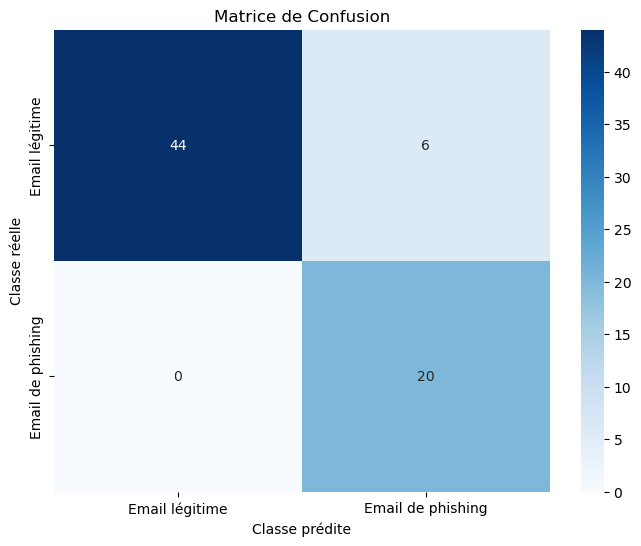

In [210]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Email légitime', 'Email de phishing'], yticklabels=['Email légitime', 'Email de phishing'])
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de Confusion')
plt.show()

In [179]:
def predir_mail(email, model):
    translated = translate_to_english_large(email)
    processed = preprocessed(translated)
    translated_features = tfidf_vectorizer.transform([processed])
    selected_features = tfidf_selector.transform(translated_features)
    
    if sp.issparse(selected_features):
        selected_features = selected_features.toarray()
    
    probabilities = model.predict(selected_features)
    text_score = Textscore(processed)
    prob_1 = probabilities[0][1] 
    
    combined_prob_1 = min(prob_1 + text_score, 1)
    
    return combined_prob_1

In [228]:
confusion_matrix_cnn = np.zeros((2, 2), dtype=int)

for email in df['Text']:
    combined_prob_1 = predir_mail(email, cnn_model)
    
    predicted_class = 1 if combined_prob_1 > 0.5 else 0
    
    true_class = df.loc[df['Text'] == email, 'true_class'].values[0]
    
    confusion_matrix_cnn[true_class, predicted_class] += 1

print("Matrice de confusion :")
print(confusion_matrix_cnn)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SelectPercentile was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

In [232]:
confusion_matrix_rnn = np.zeros((2, 2), dtype=int)

for email in df['Text']:
    combined_prob_1 = predir_mail(email, rnn_model)
    
    predicted_class = 1 if combined_prob_1 > 0.5 else 0
    
    true_class = df.loc[df['Text'] == email, 'true_class'].values[0]
    
    confusion_matrix_rnn[true_class, predicted_class] += 1

print("Matrice de confusion :")
print(confusion_matrix_rnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

# 3 - Analyser les entetes

In [184]:
text_analys1 = balanced.copy()

In [185]:
import re
import dns.resolver

blacklist_keywords = [
    "Account", "Debit", "Recently",
    "Access", "Information", "Risk",
    "Bank", "Log", "Security",
    "Client", "Notification", "Service",
    "Confirm", "Password", "User",
    "Credit", "Pay", "Urgent"
]

In [186]:
def analyze_email_headers(header):
    from_field = extract_from_field(header)
    to_field = extract_to_field(header)
    subject = extract_subject(header)
    date = extract_date(header)
    
    validated_emails = validate_dns(header)
    
    dkim_verified = check_dkim(header)
    spf_verified = check_spf(header)
    
    is_blacklisted = check_blacklist(header, blacklist_keywords)
    
    additional_analysis = perform_additional_analysis(header)
    
    header_score = calculate_header_score(validated_emails, dkim_verified, spf_verified, is_blacklisted, additional_analysis)
    
    return header_score

def extract_from_field(header):
    matches = re.findall(r"From:.*?<(.*?)>", header)
    if matches:
        return matches[0].strip()
    else:
        return ""

def extract_to_field(header):
    matches = re.findall(r"To:.*?<(.*?)>", header)
    if matches:
        return matches[0].strip()
    else:
        return ""

def extract_subject(header):
    matches = re.findall(r"Subject: (.*?)$", header, re.MULTILINE)
    if matches:
        return matches[0].strip()
    else:
        return ""

def extract_date(header):
    matches = re.findall(r"Date: (.*?)$", header, re.MULTILINE)
    if matches:
        return matches[0].strip()
    else:
        return ""

def validate_dns(header):
    validated_emails = []
    received_lines = re.findall(r"Received:.*", header)
    
    for line in received_lines:
        hostname = re.search(r"from\s(.*?)\s", line)
        if hostname:
            hostname = hostname.group(1)
            try:
                answers = dns.resolver.resolve(hostname, 'A')
                if answers:
                    validated_emails.append(hostname)
            except dns.resolver.NoAnswer:
                pass
            except dns.resolver.NXDOMAIN:
                pass
    
    return validated_emails

def check_dkim(header):
    dkim_signature = re.findall(r"DKIM-Signature:\s(.*?)\s", header)
    if dkim_signature:
        return True
    else:
        return False

def check_spf(header):
    received_spf = re.findall(r"Received-SPF:.*?pass", header)
    if received_spf:
        return True
    else:
        return False

def check_blacklist(header, blacklist_keywords):
    for keyword in blacklist_keywords:
        if re.search(r"\b{}\b".format(keyword), header, flags=re.IGNORECASE):
            return True
    return False

def perform_additional_analysis(header):
    additional_results = {}
    
    x_mailman_version = re.findall(r"X-Mailman-Version:\s(.*?)\s", header)
    if x_mailman_version:
        additional_results['X-Mailman-Version'] = x_mailman_version[0].strip()
    
    x_spam_flag = re.findall(r"X-Spam-Flag:\s(.*?)\s", header)
    if x_spam_flag:
        additional_results['X-Spam-Flag'] = x_spam_flag[0].strip()
    
    x_virus_scanned = re.findall(r"X-Virus-Scanned:\s(.*?)\s", header)
    if x_virus_scanned:
        additional_results['X-Virus-Scanned'] = x_virus_scanned[0].strip()
        
    return additional_results


In [187]:
def calculate_header_score(validated_emails, dkim_verified, spf_verified, is_blacklisted, additional_analysis):
    score = 0
    
    if dkim_verified:
        score += 20
    if spf_verified:
        score += 20
    
    if validated_emails:
        score += 20
    
    if is_blacklisted:
        score -= 30
    
    for key, value in additional_analysis.items():
        for keyword in blacklist_keywords:
            if re.search(r"\b{}\b".format(keyword), value, flags=re.IGNORECASE):
                score -= 10
                break
    
    return score

text_analys1['header_score'] = text_analys1['entete'].apply(analyze_email_headers)

In [188]:
text_analys1.head()

,id,entete,class,corps_decode,liens,header_score
0,8,"""Bernadine W. Sykes"" <wsykespg@ebay.com>;username@domain.com;nan;nan;=?ISO-8859-1?b?RWJheSBBY2NvdW50IFJldmlldyAgICA0bA==?=;Thu, 17 Jun 2004 23:09:00 +0000;<...",1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.01 Transitional//EN""\n""http://www.w3.org/TR/html4/loose.dtd"">\n<html>\n<head>\n<title>Untitled Document</title>\n<...","[http://www.w3.org/TR/html4/loose.dtd, http://www.ebay.com, http://pics.ebaystatic.com/aw/pics/navbar/eBayLogoTM.gif, http://80.253.192.38/ebay/, http://scg...",0
1,9,"""SweepsRewards"" <sweepsrewards-service@sweepsrewards.com>;username@domain.com;nan;nan;How will you spend your 500 at eBay;Fri, 17 Jun 2005 16:36:28 -0400;<2...",1,To report spam please visit our site at\nhttp://sweepsrewards.com/abuse/sweepsrewards/908824033/85.\n*******************************************************...,"[http://sweepsrewards.com/abuse/sweepsrewards/908824033/85., http://sweepsrewards.com/list/sweepsrewards/?p=unsub&pre=l&e=908824033&pw=ls7glw5qql, http://c....",-30
2,11,"PayPal <paypal@email.paypal.com>;username@domain.com;nan;nan;Security Center Advisory;Sat, 18 Jun 2005 21:59:53 -0400;<200506190159.j5J1xrxZ018230@thecotch....",1,"\n<html>\n<head>\n<title>PayPal</title>\n<style type=""text/css"">\n#message .dummy {}\n#message, #message TD {font-family: verdana,arial,helvetica,sans-serif...","[https://www.paypal.com/us, http://images.paypal.com/en_US/i/logo/email_logo.gif, http://images.paypal.com/images/bg_clk.gif, http://images.paypal.com/image...",-30
3,12,"security@paypal.com <service@paypal.com>;username@domain.com;nan;nan;Urgent PayPal security notification;Sun, 19 Jun 2005 08:35:31 -0400;<E1Djz1P-0003AP-9M@...",1,"\n<html>\n\n<head>\n<meta http-equiv=""Content-Type"" content=""text/html; charset=windows-1252"">\n<meta name=""GENERATOR"" content=""Microsoft FrontPage 4.0"">\n<...","[http://www.paypalllaa.biz/ppverify.php?cmd=_login-run&mail=&?motd=account_verify, http://images.paypal.com/en_US/i/logo/email_logo.gif, http://images.paypa...",-30
4,13,"NCUA <acc-validity@ncua.gov>;username@domain.com;nan;nan;System maintenance: update your Federal Credit Union;Sun, 19 Jun 2005 10:18:25 -0500;<E1Dk1Z3-0005g...",1,"<HTML>\n<HEAD>\n<META content=""MSHTML 6.00.2900.2627"" name=GENERATOR></HEAD>\n<BODY vLink=#ff0000 aLink=#0000ff link=#ff0000 bgColor=#ffffff leftMargin=0\nt...","[http://www.ncua.gov/images/prop/bannerStabwide2.jpg, http://www.ncua.gov/index.html, http://www.ncua.gov/images/prop/blueseal98.gif, http://www.ncua.gov/, ...",-30


In [189]:
text_analys1.tail()

,id,entete,class,corps_decode,liens,header_score
4553,2274,"michelle.cash@enron.com;twanda.sweet@enron.com;nan;nan;Foem B sign date;Mon, 15 May 2000 07:04:00 -0700 (PDT);<4654429.1075863723151.JavaMail.evans@thyme>;nan",0,"Twanda, we need executables. Michelle\n\n----- Forwarded by Michelle Cash/HOU/ECT on 05/15/2000 02:04 PM -----\n\n\tJennifer Jordan@ENRON\n\t05/15/2000 11:...",[],0
4554,2275,"lynn.blair@enron.com;michele.winckowski@enron.com, bill.fowler@enron.com, linda.trevino@enron.com;ranelle.paladino@enron.com, john.buchanan@enron.com, lynn....",0,\tI think it would be very prudent to put something on the WEB. We talked about this at the\n\tWinter Ops meeting and it would be good to have another remi...,[],0
4555,2276,"outlook-migration-team@enron.com;nan;nan;nan;Place on-call schedule on LAN;Thu, 17 May 2001 17:36:47 -0700 (PDT);<15503603.1075852731420.JavaMail.evans@thym...",0,Create on call list for 2000 and set-up directory on Victoria LAN.\nAssigned to: CN=Jeff Arnold/OU=GCO/O=Enron\nUpdated by: CN=Jeff Arnold/OU=GCO/O=Enron\n,[],0
4556,2277,"shelley.corman@enron.com;sheila.nacey@enron.com;nan;nan;Re:;Wed, 12 Dec 2001 08:35:06 -0800 (PST);<2597629.1075861075364.JavaMail.evans@thyme>;nan",0,I would like an updated copy of the schedule you brought me with adescription from the reps about why the customer is saying that they haven't paid. Especi...,[],0
4557,2278,"lwbthemarine@alltel.net;eric.bass@enron.com;nan;nan;Re: Your E-mail;Wed, 23 Jan 2002 06:56:45 -0800 (PST);<24046250.1075840322403.JavaMail.evans@thyme>;nan",0,"\nThat is all it was, Fairfield weather forecast for the wedding dates.\nSemi-cold and overcast. You can get the same info on line. How are you?-Dad\n\n\n\n...",[],0


# 4 - Analyser les liens

In [190]:
text_analys2 = balanced.copy()

In [191]:
text_analys2.head()

,id,entete,class,corps_decode,liens
0,8,"""Bernadine W. Sykes"" <wsykespg@ebay.com>;username@domain.com;nan;nan;=?ISO-8859-1?b?RWJheSBBY2NvdW50IFJldmlldyAgICA0bA==?=;Thu, 17 Jun 2004 23:09:00 +0000;<...",1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.01 Transitional//EN""\n""http://www.w3.org/TR/html4/loose.dtd"">\n<html>\n<head>\n<title>Untitled Document</title>\n<...","[http://www.w3.org/TR/html4/loose.dtd, http://www.ebay.com, http://pics.ebaystatic.com/aw/pics/navbar/eBayLogoTM.gif, http://80.253.192.38/ebay/, http://scg..."
1,9,"""SweepsRewards"" <sweepsrewards-service@sweepsrewards.com>;username@domain.com;nan;nan;How will you spend your 500 at eBay;Fri, 17 Jun 2005 16:36:28 -0400;<2...",1,To report spam please visit our site at\nhttp://sweepsrewards.com/abuse/sweepsrewards/908824033/85.\n*******************************************************...,"[http://sweepsrewards.com/abuse/sweepsrewards/908824033/85., http://sweepsrewards.com/list/sweepsrewards/?p=unsub&pre=l&e=908824033&pw=ls7glw5qql, http://c...."
2,11,"PayPal <paypal@email.paypal.com>;username@domain.com;nan;nan;Security Center Advisory;Sat, 18 Jun 2005 21:59:53 -0400;<200506190159.j5J1xrxZ018230@thecotch....",1,"\n<html>\n<head>\n<title>PayPal</title>\n<style type=""text/css"">\n#message .dummy {}\n#message, #message TD {font-family: verdana,arial,helvetica,sans-serif...","[https://www.paypal.com/us, http://images.paypal.com/en_US/i/logo/email_logo.gif, http://images.paypal.com/images/bg_clk.gif, http://images.paypal.com/image..."
3,12,"security@paypal.com <service@paypal.com>;username@domain.com;nan;nan;Urgent PayPal security notification;Sun, 19 Jun 2005 08:35:31 -0400;<E1Djz1P-0003AP-9M@...",1,"\n<html>\n\n<head>\n<meta http-equiv=""Content-Type"" content=""text/html; charset=windows-1252"">\n<meta name=""GENERATOR"" content=""Microsoft FrontPage 4.0"">\n<...","[http://www.paypalllaa.biz/ppverify.php?cmd=_login-run&mail=&?motd=account_verify, http://images.paypal.com/en_US/i/logo/email_logo.gif, http://images.paypa..."
4,13,"NCUA <acc-validity@ncua.gov>;username@domain.com;nan;nan;System maintenance: update your Federal Credit Union;Sun, 19 Jun 2005 10:18:25 -0500;<E1Dk1Z3-0005g...",1,"<HTML>\n<HEAD>\n<META content=""MSHTML 6.00.2900.2627"" name=GENERATOR></HEAD>\n<BODY vLink=#ff0000 aLink=#0000ff link=#ff0000 bgColor=#ffffff leftMargin=0\nt...","[http://www.ncua.gov/images/prop/bannerStabwide2.jpg, http://www.ncua.gov/index.html, http://www.ncua.gov/images/prop/blueseal98.gif, http://www.ncua.gov/, ..."


In [192]:
text_analys2.drop(['entete', 'corps_decode'], axis=1, inplace=True)

In [193]:
print(text_analys2['liens'].iloc[0])

['http://www.w3.org/TR/html4/loose.dtd', 'http://www.ebay.com', 'http://pics.ebaystatic.com/aw/pics/navbar/eBayLogoTM.gif', 'http://80.253.192.38/ebay/', 'http://scgi.ebay.com/verify_id=ebay']


In [194]:
def calculate_domain_length_score(domain):
    max_domain_length = 20  
    if len(domain) <= max_domain_length:
        return 1.0  # Safe
    else:
        return 0  # Less safe

In [195]:
def calculate_path_length_score(path):
    max_path_length = 30  
    if len(path) <= max_path_length:
        return 1.0  # Safe
    else:
        return 0  # Less safe

In [196]:
def calculate_query_params_score(query):
    max_query_params = 3  
    num_params = len(query.split('&'))
    if num_params <= max_query_params:
        return 1.0  # Safe
    else:
        return 0 # Less safe

In [197]:
def combine_scores(features):
    total_score = sum(features.values()) / len(features)
    return total_score

In [198]:
from urllib.parse import urlparse
import tldextract

def extract_features(url):
    # Analyse l'URL en ses composants
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    path = parsed_url.path
    query = parsed_url.query

    # Extrait les informations du TLD (domaine de premier niveau)
    tld_info = tldextract.extract(url)
    tld = tld_info.suffix 

    # Calcule les scores des fonctionnalités individuelles
    features = {
        'domain_length_score': calculate_domain_length_score(domain),
        'path_length_score': calculate_path_length_score(path),
        'query_params_score': calculate_query_params_score(query),
    }

    # Calcule le score basé sur le nombre de sous-domaines
    num_subdomains = len(tld_info.subdomain.split('.')) 
    features['subdomain_count_score'] = 1 - (num_subdomains / 5)  
    
    # Pénalise si des caractères inhabituels sont présents dans le domaine
    unusual_chars_penalty = 0 if any(char.lower() not in 'abcdefghijklmnopqrstuvwxyz.-' for char in domain) else 1.0
    features['unusual_char_score'] = unusual_chars_penalty 

    # Pénalise si le domaine utilise un raccourcisseur d'URL connu
    shortener_penalty = 0 if any(shortener in domain for shortener in ['bit.ly', 'tinyurl']) else 1.0
    features['shortener_score'] = shortener_penalty 

    # Pénalise si le TLD n'est pas dans une liste de confiance (com, org, net)
    tld_penalty = 0 if tld not in ['com', 'org', 'net'] else 1.0 
    features['tld_score'] = tld_penalty
    
    # Vérifie si l'URL utilise HTTPS
    https_penalty = 0 if parsed_url.scheme == 'https' else 1.0
    features['https_score'] = https_penalty

    # Vérifie s'il y a une redirection dans l'URL
    redirect_penalty = 0 if '//' not in url else 1.0
    features['redirect_score'] = redirect_penalty

    # Combine les scores des fonctionnalités individuelles en un score final
    final_score = combine_scores(features)
        
    return final_score


In [199]:
def calculate_min_phishing_score(urls):
    if not urls:  
        return 0
    scores = [extract_features(url) for url in urls]
    return max(scores)
 

text_analys2['link_score'] = text_analys2['liens'].apply(calculate_min_phishing_score)

In [200]:
text_analys2.head()

,id,class,liens,link_score
0,8,1,"[http://www.w3.org/TR/html4/loose.dtd, http://www.ebay.com, http://pics.ebaystatic.com/aw/pics/navbar/eBayLogoTM.gif, http://80.253.192.38/ebay/, http://scg...",0.977778
1,9,1,"[http://sweepsrewards.com/abuse/sweepsrewards/908824033/85., http://sweepsrewards.com/list/sweepsrewards/?p=unsub&pre=l&e=908824033&pw=ls7glw5qql, http://c....",0.866667
2,11,1,"[https://www.paypal.com/us, http://images.paypal.com/en_US/i/logo/email_logo.gif, http://images.paypal.com/images/bg_clk.gif, http://images.paypal.com/image...",0.977778
3,12,1,"[http://www.paypalllaa.biz/ppverify.php?cmd=_login-run&mail=&?motd=account_verify, http://images.paypal.com/en_US/i/logo/email_logo.gif, http://images.paypa...",0.977778
4,13,1,"[http://www.ncua.gov/images/prop/bannerStabwide2.jpg, http://www.ncua.gov/index.html, http://www.ncua.gov/images/prop/blueseal98.gif, http://www.ncua.gov/, ...",0.977778


In [201]:
text_analys2.tail()

,id,class,liens,link_score
4553,2274,0,[],0.0
4554,2275,0,[],0.0
4555,2276,0,[],0.0
4556,2277,0,[],0.0
4557,2278,0,[],0.0


# 5 - Combiner les scores

In [202]:
phish="C:\\Users\\user\\Desktop\\Phishing email Dataset\\Data\\phishing-bilingual.csv"
phish = pd.read_csv(phish)
phish.head()

,No.,English Text,Arabic Text
0,0,"Dear email owner/recipient,\n\nWe have already sent you this letter without hearing from you, I'm not sure you got it, that's why I repeat.\n\nMy name is Ms...",عزيزي مالك / مستلم البريد الإلكتروني ،\n\nلقد أرسلنا لك هذه الرسالة مسبقًا دون أن أسمع منك ، لست متأكدًا من أنك حصلت عليها ، ولهذا أكرر.\n\nاسمي السيدة كريس...
1,1,"Hello Ahmed Abbas, I am using a translator so that we can communicate better\nI have been looking for someone with this last name Abbas, so when I saw your ...",مرحباً أحمد عباس ، أنا أستخدم مترجمًا حتى نتواصل بشكل أفضل\nلقد كنت أبحث عن شخص يحمل هذا الاسم الأخير عباس ، لذلك عندما رأيت ملفك الشخصي على Facebook ، قررت...
2,2,"Hello, I'm a hiring manager at Amazon and we're currently looking for a part-time online employee working from home using the phone\nMobile, you can easily ...",مرحبا، أنا مدير توظيف في أمازون ونبحث حاليا عن موظفا عبر الانترنت بدوام جزئي بالعمل من المنزل باستخدام الهاتف \nالمحمول، يمكنك بسهولة كسب 1000 الى 3000 جني...
3,3,"Personal banking services - Riyad Bank\nSecurity alert\ndear customer,\nWe inform you that due to the ongoing maintenance of public order in our online bank...",الخدمات المصرفية للأفراد – بنك الرياض\nانذار امني\nعزيزي الزبون،\nنعلمك أنه نظرا لاستمرار صيانة النظام العام في قاعدة بياناتنا المصرفية عبر الانترنت، فانه ا...
4,4,"Security alert\ndear customer,\nWe inform you that due to the ongoing maintenance of public order in our online banking database, it is mandatory for you to...",اانذار امني\nعزيزي الزبون،\nنعلمك أنه نظرا لاستمرار صيانة النظام العام في قاعدة بياناتنا المصرفية عبر الانترنت، فانه الزامي عليك التحقق من حساب المباشر للأف...


In [203]:
phish.drop(['English Text'], axis=1, inplace=True)
phish.drop(['No.'], axis=1, inplace=True)

In [204]:
phish.head()

,Arabic Text
0,عزيزي مالك / مستلم البريد الإلكتروني ،\n\nلقد أرسلنا لك هذه الرسالة مسبقًا دون أن أسمع منك ، لست متأكدًا من أنك حصلت عليها ، ولهذا أكرر.\n\nاسمي السيدة كريس...
1,مرحباً أحمد عباس ، أنا أستخدم مترجمًا حتى نتواصل بشكل أفضل\nلقد كنت أبحث عن شخص يحمل هذا الاسم الأخير عباس ، لذلك عندما رأيت ملفك الشخصي على Facebook ، قررت...
2,مرحبا، أنا مدير توظيف في أمازون ونبحث حاليا عن موظفا عبر الانترنت بدوام جزئي بالعمل من المنزل باستخدام الهاتف \nالمحمول، يمكنك بسهولة كسب 1000 الى 3000 جني...
3,الخدمات المصرفية للأفراد – بنك الرياض\nانذار امني\nعزيزي الزبون،\nنعلمك أنه نظرا لاستمرار صيانة النظام العام في قاعدة بياناتنا المصرفية عبر الانترنت، فانه ا...
4,اانذار امني\nعزيزي الزبون،\nنعلمك أنه نظرا لاستمرار صيانة النظام العام في قاعدة بياناتنا المصرفية عبر الانترنت، فانه الزامي عليك التحقق من حساب المباشر للأف...


In [205]:
phish = phish.rename(columns={'Arabic Text': 'email'})

In [206]:
legit="C:\\Users\\user\\Desktop\\Phishing email Dataset\\Data\\legit-bilingual.csv"
legit = pd.read_csv(legit)
legit.head()

,No.,Arabic Text,English Text
0,0,"Thank you for your reply, the local NSM response was not as kind. I am eager to learn and am greatful for your kindness. I want to be a part of the party; I...",شكرًا لك على ردك ، لم يكن رد NSM المحلي بهذا اللطف. أنا حريص على التعلم وأنا ممتن لطفك. أريد أن أكون جزءًا من الحفلة ؛ يمكنني أن أقدم قدرتي الفنية بأسلوب ال...
1,1,"Daniele Milan updated a event in the TENTATIVE ACTIVITY In Office Actitities (Training - Delivery - Ecc) calendar Jun 09, 2014 Until Jun 13, 2014 KNB Adva...",قام دانييل ميلان بتحديث حدث في تقويم النشاط المؤقت في المكتب (التدريب - التسليم - Ecc) 09 يونيو 2014 حتى 13 يونيو 2014 تدريب KNB المتقدم أنت تتلقى هذا الإشع...
2,2,<x-flowed>\nEd:\nI just waded through all the correspondence with Mike re the Science paper \nand Keef's commentary. I wish to disassociate myself with Mik...,لقد خاضت للتو في جميع المراسلات مع مايك بخصوص ورقة العلوم\nوشرح كيف. أرغب في عدم الارتباط بتعليقات مايك ،\nأو على الأقل لهجة منهم. أنا لا أعتبر نفسي الحكم ا...
3,3,Thank you!\nJordan C. Vaughn\nNational AALC Finance Director\nDemocratic National Committee\n(202) 488-5089<tel:(202)%20488-5089> (o) | (407) 797-2215<tel:(...,شكرا لك!\nجوردان سي فون\nالمدير المالي الوطني AALC\nاللجنة الوطنية الديمقراطية\n(202) 488-5089 <الهاتف: (202)? 20488-5089> (س) | (407) 797-2215 <الهاتف: (40...
4,4,"Dear Keith,\nThank you for the message of 5 June, 1997.\nI am anderstanding your difficulties with transfering money and I\nthink the best way for us if you...",عزيزي كيث ،\nشكرا على الرسالة المؤرخة 5 حزيران / يونيو 1997.\nأتفهم الصعوبات التي تواجهك في تحويل الأموال وأنا\nفكر في أفضل طريقة لنا إذا كنت ستجلب الأموال ...


In [207]:
legit.drop(['Arabic Text'], axis=1, inplace=True)
legit.drop(['No.'], axis=1, inplace=True)

In [208]:
legit.head()

,English Text
0,شكرًا لك على ردك ، لم يكن رد NSM المحلي بهذا اللطف. أنا حريص على التعلم وأنا ممتن لطفك. أريد أن أكون جزءًا من الحفلة ؛ يمكنني أن أقدم قدرتي الفنية بأسلوب ال...
1,قام دانييل ميلان بتحديث حدث في تقويم النشاط المؤقت في المكتب (التدريب - التسليم - Ecc) 09 يونيو 2014 حتى 13 يونيو 2014 تدريب KNB المتقدم أنت تتلقى هذا الإشع...
2,لقد خاضت للتو في جميع المراسلات مع مايك بخصوص ورقة العلوم\nوشرح كيف. أرغب في عدم الارتباط بتعليقات مايك ،\nأو على الأقل لهجة منهم. أنا لا أعتبر نفسي الحكم ا...
3,شكرا لك!\nجوردان سي فون\nالمدير المالي الوطني AALC\nاللجنة الوطنية الديمقراطية\n(202) 488-5089 <الهاتف: (202)? 20488-5089> (س) | (407) 797-2215 <الهاتف: (40...
4,عزيزي كيث ،\nشكرا على الرسالة المؤرخة 5 حزيران / يونيو 1997.\nأتفهم الصعوبات التي تواجهك في تحويل الأموال وأنا\nفكر في أفضل طريقة لنا إذا كنت ستجلب الأموال ...


In [209]:
legit = legit.rename(columns={'English Text': 'email'})

In [210]:
phish['true_class'] = 1
legit['true_class'] = 0
df2 = pd.concat([phish, legit])

In [211]:
df2

,email,true_class
0,عزيزي مالك / مستلم البريد الإلكتروني ،\n\nلقد أرسلنا لك هذه الرسالة مسبقًا دون أن أسمع منك ، لست متأكدًا من أنك حصلت عليها ، ولهذا أكرر.\n\nاسمي السيدة كريس...,1
1,مرحباً أحمد عباس ، أنا أستخدم مترجمًا حتى نتواصل بشكل أفضل\nلقد كنت أبحث عن شخص يحمل هذا الاسم الأخير عباس ، لذلك عندما رأيت ملفك الشخصي على Facebook ، قررت...,1
2,مرحبا، أنا مدير توظيف في أمازون ونبحث حاليا عن موظفا عبر الانترنت بدوام جزئي بالعمل من المنزل باستخدام الهاتف \nالمحمول، يمكنك بسهولة كسب 1000 الى 3000 جني...,1
3,الخدمات المصرفية للأفراد – بنك الرياض\nانذار امني\nعزيزي الزبون،\nنعلمك أنه نظرا لاستمرار صيانة النظام العام في قاعدة بياناتنا المصرفية عبر الانترنت، فانه ا...,1
4,اانذار امني\nعزيزي الزبون،\nنعلمك أنه نظرا لاستمرار صيانة النظام العام في قاعدة بياناتنا المصرفية عبر الانترنت، فانه الزامي عليك التحقق من حساب المباشر للأف...,1
...,...,...
145,مرحبا تيم ، مرحبا كيث ،\nمرفقًا يمكنك العثور على إعادة إعمار درجة حرارة موسم البرد\nالشذوذ. لقد احتفظت بـ EOFs الثالث والرابع والخامس والسادس طوال الوقت\nتم...,0
146,اقرأ جميع القصص الجديدة عن الطعام والنبيذ\nانقر هنا لعرضها على شبكة الإنترنت.\nالغذاء والنبيذ\n<<link>>: //www.foodandwine.com/slideshows/garlic#! slide = 1...,0
147,"\nقام دانييل ميلان بتحديث حدث ""السفر"" في تقويم النشاط المؤقت مايو 2728 ، 2014 حتى 28 مايو 2014 طوال اليوم ماركو كاتينو ، ماسيميليانو لوبي تل أبيب ، مناقشة ق...",0
148,مرحبًا بالجميع = 97 ، نرسل 92ll هذا يوم السبت إلى الأشخاص الذين أخذوا Bernie anno =\nعمل unement العام الماضي. أخبرنا إذا كان لديك أي أعلام ، وشكراً.\n[الرق...,0


In [212]:
df_shuffled = df2.sample(frac=1.0, random_state=42).reset_index(drop=True)

In [213]:
df_shuffled

,email,true_class
0,أصدرت شركة Gartner للتو تقرير Magic Quadrant لعام 2021 لأنظمة إدارة قواعد البيانات السحابية ، وتم اختيار Databricks كرائد لأول مرة. وهذا يجعل Databricks هو ...,0
1,يخطط فريق TEAM PAC للانطلاق. على أي حال ، سمعت أن Microsoft تنظم أحداثًا مذهلة. أجبان صغيرة مشوية رائعة.,0
2,لقد خاضت للتو في جميع المراسلات مع مايك بخصوص ورقة العلوم\nوشرح كيف. أرغب في عدم الارتباط بتعليقات مايك ،\nأو على الأقل لهجة منهم. أنا لا أعتبر نفسي الحكم ا...,0
3,عزيزي عضو البطاقة ،\nيتطلب حساب بطاقتك انتباهك. شكرًا لك على تقديم عنوان حديث لحساب أمريكان إكسبريس الخاص بك.\n\nأمنك مهم جدًا بالنسبة لنا ، يرجى تحديث معلو...,1
4,<x- متدفق>\nمرحبا كيث ،\nبالتأكيد لا ، وآسف لعدم التوضيح. هذا هو الرد على\nJ. تعليق المناخ من قبل Von Storch الذي نتحدث عنه هنا. ال\nالمسودة النهائية مستحقة...,0
...,...,...
295,أدريان ،\nأعاد خادم ECMWF رسائل البريد الإلكتروني إلى Kate أمس (لبريدك الإلكتروني\nالعنوان) ولكن ليس لديك؟\nلقد وجدت أيضًا رسالتي البريد الإلكتروني اللذين أ...,0
296,البنك الاهلي المصري يطالبكم بضرورة سداد بمبلغ 108 جنية مصري للبطاقة الائتمانية وذلك تجنبا للغرامة والايقاف بجد اقصى يوم 13/3,1
297,لقد تم تخصيص مبلغ 5،000،000.00 دولار أمريكي (خمسة ملايين دولار أمريكي) في مراسلات مع صناديق الإغاثة من جائحة COVID19. ارجع للتحقق من الأعمال الورقية والدفع....,1
298,شكرًا جزيلاً على المساهمة في / Future\nالإنترنت / في عام 2021. لقد نشرنا 321 بحثًا في عام 2021 وقمنا بتحسين كبير مقارنة ببيانات عام 2020. لا يمكننا تحقيق إن...,0


In [214]:
data = df_shuffled.copy()